In [3]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random

# For stars w/Prot

crossmatch with McQuillian stars

In [2]:
# read in McQuillian stars
McQS = pd.read_table('https://arxiv.org/src/1402.5694v2/anc/Table_1_Periodic.txt',delimiter=',',skiprows=1,names=('KID','Teff','logg','Mass','Prot','Prot_err','Rper','LPH','w','DC','Flag'))
MCQS_t2=pd.read_table('https://arxiv.org/src/1402.5694v2/anc/Table_2_Non_Periodic.txt',delimiter=',',skiprows=1,names=('KID','Teff','logg','Mass','Prot','Prot_err','LPH','w','DC'))
print('McQuillian T2 before dropping',np.shape(MCQS_t2))
MCQS_t2=MCQS_t2.dropna(subset=['Prot'])
print('McQuillian',np.shape(McQS))
print('McQuillian T2 after dropping',np.shape(MCQS_t2))

# gaia data from https://gaia-kepler.fun/
with fits.open('../FirstYearML/kepler_dr2_1arcsec.fits') as data_ga:
    gaia = pd.DataFrame(data_ga[1].data, dtype="float64")

# merge two tables with same KID
df = pd.concat([McQS[MCQS_t2.columns], MCQS_t2])

print('McQuillian T1+T2',np.shape(df))
df = pd.merge(df, gaia, left_on="KID", right_on="kepid", how="inner")


# drop duplicates
df = df.drop_duplicates(subset ="KID", keep = 'first') 
print('Cross-matched',np.shape(df))
print('Missing %d stars'%(np.shape(McQS)[0]+np.shape(MCQS_t2)[0]-np.shape(df)[0]))

McQuillian T2 before dropping (99000, 9)
McQuillian (34030, 11)
McQuillian T2 after dropping (30754, 9)
McQuillian T1+T2 (64784, 9)
Cross-matched (64624, 143)
Missing 160 stars


In [5]:
# calculate v_b's
df['v_t'],df['v_b']=Astraea.getVs(df)

## for each star find its 50 nearest in Temp vs Period and calculate velocity dispersion
### try clustering..

In [ ]:
default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 500,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}


X = StandardScaler().fit_transform(df[['teff','Prot']])
params = default_base.copy()
bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])


connectivity = kneighbors_graph(X, n_neighbors=params['n_neighbors'], include_self=False)

# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

spectral = cluster.SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")

spectral.fit(X)

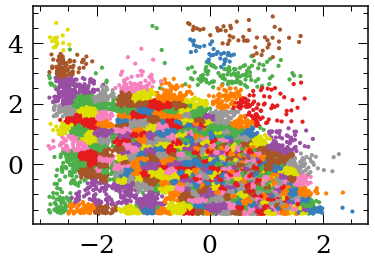

In [40]:
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
y_pred = spectral.labels_.astype(np.int)

plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

Text(0, 0.5, 'Rotation Periods [days]')

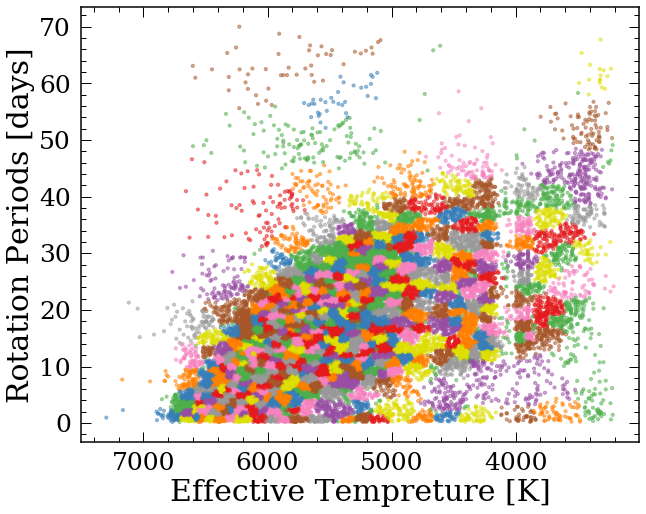

In [41]:
# plot tempreture vs Prot
plt.figure(figsize=(10,8))
plt.scatter(df['teff'],df['Prot'],s=10,alpha=0.5,color=colors[y_pred])

plt.xlabel('Effective Tempreture [K]')
plt.gca().invert_xaxis()
plt.ylabel('Rotation Periods [days]')

### Try nearest neighbors

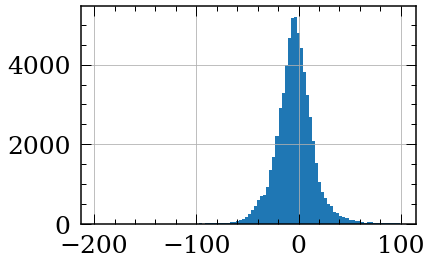

In [8]:
df['v_b'].hist(bins=100)


In [7]:
# use the normaized teff vs Prot
X_nn = StandardScaler().fit_transform(df[['teff','Prot']])
df['teff_norm'],df['Prot_norm'] = X_nn[:,0], X_nn[:,1]

print('before dropping',len(df))
df=df.dropna(subset=['v_b'])
print('after dropping',len(df))

df=df.loc[df['v_b']<100].reset_index(drop=True)
df=df.loc[df['v_b']>-200].reset_index(drop=True)

# for each star calculate its nearest *NN* stars and calcualte velocity dispersion
Nstars=len(df)


before dropping 64624
after dropping 63106


In [9]:
def m_to_M(m, D):
    """
    Convert apparent magnitude to absolute magnitude.
    """
    return m - 5*np.log10(D)-10

df["abs_G"] = m_to_M(df.phot_g_mean_mag.values, 1./df.parallax.values)
df=df.dropna(subset=["abs_G"])

In [10]:
z = np.polyfit(df['teff'], df['abs_G'], 6)
p = np.poly1d(z)


In [11]:
df=df.loc[df['w']>0.15]

Text(0, 0.5, 'abs_g')

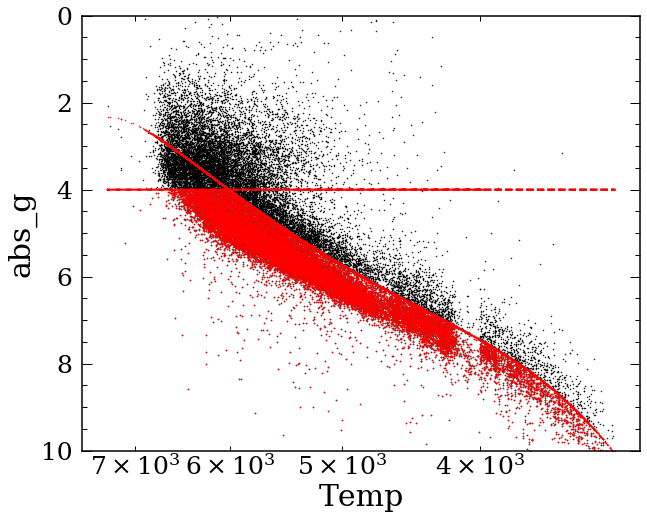

In [12]:
plt.figure(figsize=(10,8))
plt.semilogx(df['teff'],df['abs_G'],'k.',markersize=1)
plt.semilogx(df['teff'],p(df['teff'])-0.1,'r.',markersize=1)
plt.plot(df['teff'],4*np.ones(len(df['teff'])),'r--')

df_w=df.loc[df['abs_G']>p(df['teff'])-0.1]
df_w=df_w.loc[df_w['abs_G']>4]
#df_w=df_w.loc[df_w["abs_G"]>20]
plt.semilogx(df_w['teff'],df_w['abs_G'],'r.',markersize=1)
plt.ylim([0,10])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xlabel('Temp')
plt.ylabel('abs_g')

In [15]:
NN=150 # how many nearest to find
Nstars=len(df_w)
X_nn = StandardScaler().fit_transform(df_w[['teff','Prot']])
df_w['teff_norm'],df_w['Prot_norm'] = X_nn[:,0], X_nn[:,1]
# initialize velocity dispersion
df_w['dv']=np.zeros(Nstars)
df_w['dv_MAD']=np.zeros(Nstars)
for i in range(Nstars):
    update_progress(i/Nstars)
    teff = df_w.iloc[i]['teff_norm']
    Prot = df_w.iloc[i]['Prot_norm']
    df_w['dist'] = np.sqrt(np.power(df_w['teff_norm']-teff,2.)+np.power(df_w['Prot_norm']-Prot,2.))
    # get the clossest stadrs v_b
    NNstars=df_w.loc[df_w.sort_values(by=['dist']).iloc[0:NN].index]
    
    MAD=sum(abs(NNstars['v_b']-np.median(NNstars['v_b'])))/float(len(NNstars))
    #print(MAD)
    df_w['dv_MAD'].iloc[i]=1.5*MAD
    df_w['dv'].iloc[i]=np.std(NNstars['v_b'])

Progress: [####################] 100.0%


In [19]:
# plot tempreture vs Prot
#df_w=pd.read_pickle('ProtVP_cutgiant.pkl')
cm = plt.cm.get_cmap('viridis',10)
plt.figure(figsize=(10,8))
df_w=df_w.dropna(subset=['dv'])
df_plotdv=df_w[['teff','Prot','dv']].sort_values(by=['dv'], ascending=False).loc[df_w['kmag']<16.]
plt.scatter(df_plotdv['teff'],df_plotdv['Prot'],c=df_plotdv['dv'],s=10,vmin=5,vmax=35, cmap=cm,edgecolors=None)

from joblib import dump, load
reg=load('NN_error_lin_model.joblib')
df_w['dv_err']=reg.predict(df_w[['teff','Prot']])*df_w['dv']

plt.xlabel('Effective Tempreture [K]')
plt.gca().invert_xaxis()
plt.ylabel('Rotation Periods [days]')

cb=plt.colorbar()
cb.set_label('Velocity dispersion')

plt.savefig('150stars_wogiant_Mcut_McT2.png')

df_w.to_pickle('ProtVP_MS_150_w015.pkl')


KeyError: "['teff_calc'] not in index"

<Figure size 720x576 with 0 Axes>

### for giants

Text(0, 0.5, 'abs_g')

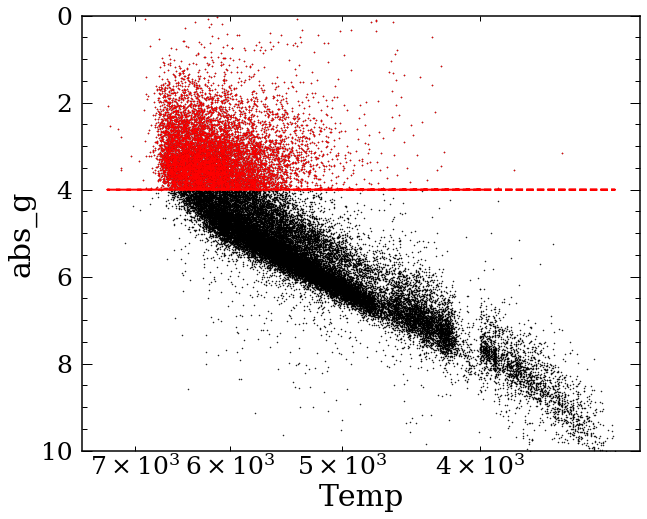

In [19]:
plt.figure(figsize=(10,8))
plt.semilogx(df['teff'],df['abs_G'],'k.',markersize=1)
plt.plot(df['teff'],4*np.ones(len(df['teff'])),'r--')

df_w_giants=df.loc[df['abs_G']<4]

plt.semilogx(df_w_giants['teff'],df_w_giants['abs_G'],'r.',markersize=1)
plt.ylim([0,10])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xlabel('Temp')
plt.ylabel('abs_g')

In [26]:
NN=200 # how many nearest to find
Nstars=len(df_w_giants)
# initialize velocity dispersion
df_w_giants['dv']=np.zeros(Nstars)
df_w_giants['dv_MAD']=np.zeros(Nstars)
X_nn = StandardScaler().fit_transform(df_w_giants[['teff','Prot']])
df_w_giants['teff_norm'],df_w_giants['Prot_norm'] = X_nn[:,0], X_nn[:,1]
for i in range(Nstars):
    update_progress(i/Nstars)
    teff = df_w_giants.iloc[i]['teff_norm']
    Prot = df_w_giants.iloc[i]['Prot_norm']
    df_w_giants['dist'] = np.sqrt(np.power(df_w_giants['teff_norm']-teff,2.)+np.power(df_w_giants['Prot_norm']-Prot,2.))
    # get the clossest stadrs v_b
    NNstars=df_w_giants.loc[df_w_giants.sort_values(by=['dist']).iloc[0:NN].index]
    
    MAD=sum(abs(NNstars['v_b']-np.median(NNstars['v_b'])))/float(len(NNstars))
    #print(MAD)
    df_w_giants['dv_MAD'].iloc[i]=1.5*MAD
    df_w_giants['dv'].iloc[i]=np.std(NNstars['v_b'])
    print(df_w['dv'].iloc[i])
    
    

Progress: [####################] 100.0%
21.064545313852356


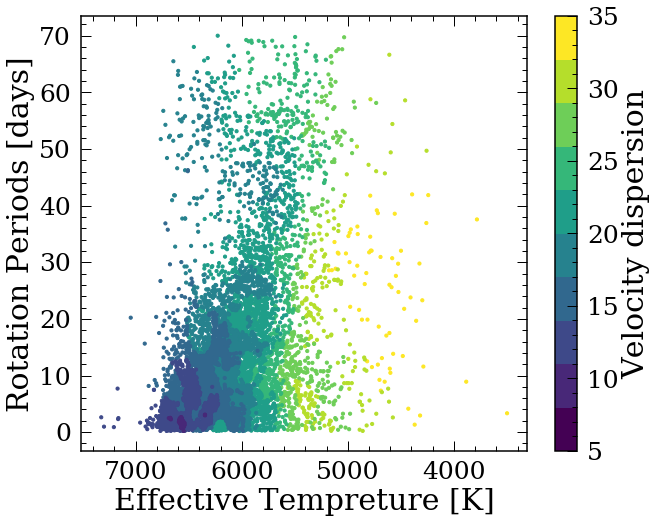

In [27]:
# plot tempreture vs Prot
#df_w=pd.read_pickle('ProtVP_cutgiant.pkl')
cm = plt.cm.get_cmap('viridis',10)
plt.figure(figsize=(10,8))
df_w_giants=df_w_giants.dropna(subset=['dv'])
df_plotdv=df_w_giants[['teff','Prot','dv']].sort_values(by=['dv'], ascending=False).loc[df_w_giants['kmag']<16.]
plt.scatter(df_plotdv['teff'],df_plotdv['Prot'],c=df_plotdv['dv'],s=10,vmin=5,vmax=35, cmap=cm,edgecolors=None)

plt.xlabel('Effective Tempreture [K]')
plt.gca().invert_xaxis()
plt.ylabel('Rotation Periods [days]')

cb=plt.colorbar()
cb.set_label('Velocity dispersion')

plt.savefig('150stars_giants_Mcut_McT2.png')
df_w_giants.to_pickle('ProtVP_giant_200_w015.pkl')


# For stars w/o Prot

Use all gaia/Kepler CM stars

In [449]:
df_nProt=gaia
df_nProt['v_t'],df_nProt['v_b']=Astraea.getVs(df_nProt)
print('before merging',len(df_nProt))
Rvars_df=pd.read_table('/Users/lucy/Desktop/FirstYearML/CSVs_2/LG_Rvar_Kepler_27.csv',delimiter=',')
df_nProt=pd.merge(df_nProt,Rvars_df,left_on='kepid',right_on='KIDs').drop_duplicates(subset ="KIDs", keep = 'first') 
print('after merging',len(df_nProt))
df_nProt=df_nProt.loc[df_nProt['kmag']<16]

before merging 201312
after merging 197322


In [450]:
max(df_nProt.kmag)

15.992

In [451]:
# use the normaized teff vs Prot
df_nProt['Rvars_27_log']=np.log10(df_nProt['Rvars_27'])
X_nn = StandardScaler().fit_transform(df_nProt[['teff','Rvars_27_log']])
df_nProt['teff_norm'],df_nProt['Rvars_27_norm'] = X_nn[:,0], X_nn[:,1]

print('before dropping',len(df_nProt))
df_nProt=df_nProt.dropna(subset=['v_b'])
print('after dropping',len(df_nProt))

# drop velocities that are very high...
df=df.loc[df['v_b']<100].reset_index(drop=True)
df=df.loc[df['v_b']>-200].reset_index(drop=True)

# for each star calculate its nearest *NN* stars and calcualte velocity dispersion
Nstars=len(df_nProt)

# initialize velocity dispersion
df_nProt['dv']=np.zeros(Nstars)

before dropping 196975
after dropping 192629


Text(0, 0.5, 'abs_g')

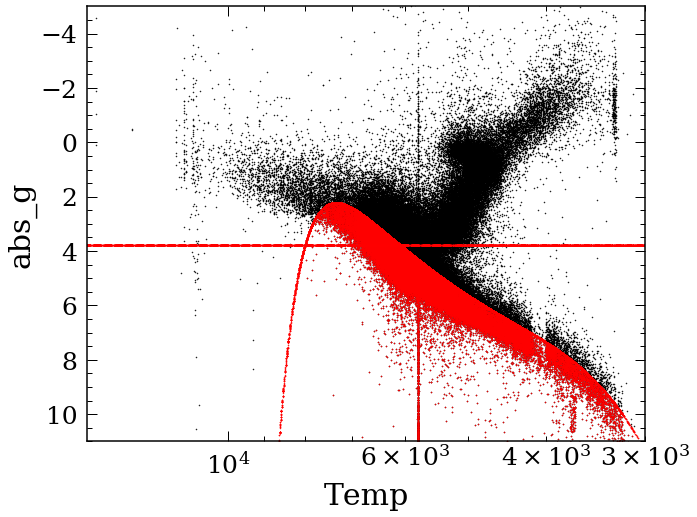

In [452]:
# cut out giants
df_nProt["abs_G"] = m_to_M(df_nProt.phot_g_mean_mag.values, 1./df_nProt.parallax.values)
df_nProt=df_nProt.dropna(subset=["abs_G"])

plt.figure(figsize=(10,8))
plt.semilogx(df_nProt['teff'],df_nProt['abs_G'],'k.',markersize=1)
plt.semilogx(df_nProt['teff'],p(df_nProt['teff'])-0.2,'r.',markersize=1)
plt.plot(df_nProt['teff'],4*np.ones(len(df_nProt['teff']))-0.2,'r--')

df_Rvar=df_nProt.loc[df_nProt['abs_G']>p(df_nProt['teff'])-0.2]
#df_w=df_w.loc[df_w["abs_G"]>20]
plt.semilogx(df_Rvar['teff'],df_Rvar['abs_G'],'r.',markersize=1)
plt.ylim([-5,11])
plt.xlim([3e3,1.5e4])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

Nstars=len(df_Rvar)

plt.xlabel('Temp')
plt.ylabel('abs_g')

In [19]:
NN=500 # how many nearest to find
for i in range(Nstars):
    update_progress(i/Nstars)
    teff = df_Rvar.iloc[i]['teff_norm']
    Prot = df_Rvar.iloc[i]['Rvars_27_norm']
    df_Rvar['dist'] = np.sqrt(np.power(df_Rvar['teff_norm']-teff,2.)+np.power(df_Rvar['Rvars_27_norm']-Prot,2.))
    # get the clossest stars v_b
    NNstars=df_Rvar.loc[df_Rvar.sort_values(by=['dist']).iloc[0:NN].index]
    
    MAD=sum(abs(NNstars['v_b']-np.median(NNstars['v_b'])))/float(len(NNstars))
    print(MAD)
    df_Rvar['dv'].iloc[i]=1.5*MAD
    

Progress: [####################] 100.0%
16.612322574086942


In [114]:
i

31572

In [21]:
#df_Rvar.to_pickle('RvarVP_cutgiant.pkl')

In [ ]:
df['v_b'].hist(bins=100)

In [ ]:
print([i for i in df_nProt.columns])
print(len(df_nProt.drop_duplicates(subset ="KIDs", keep = 'first') ))

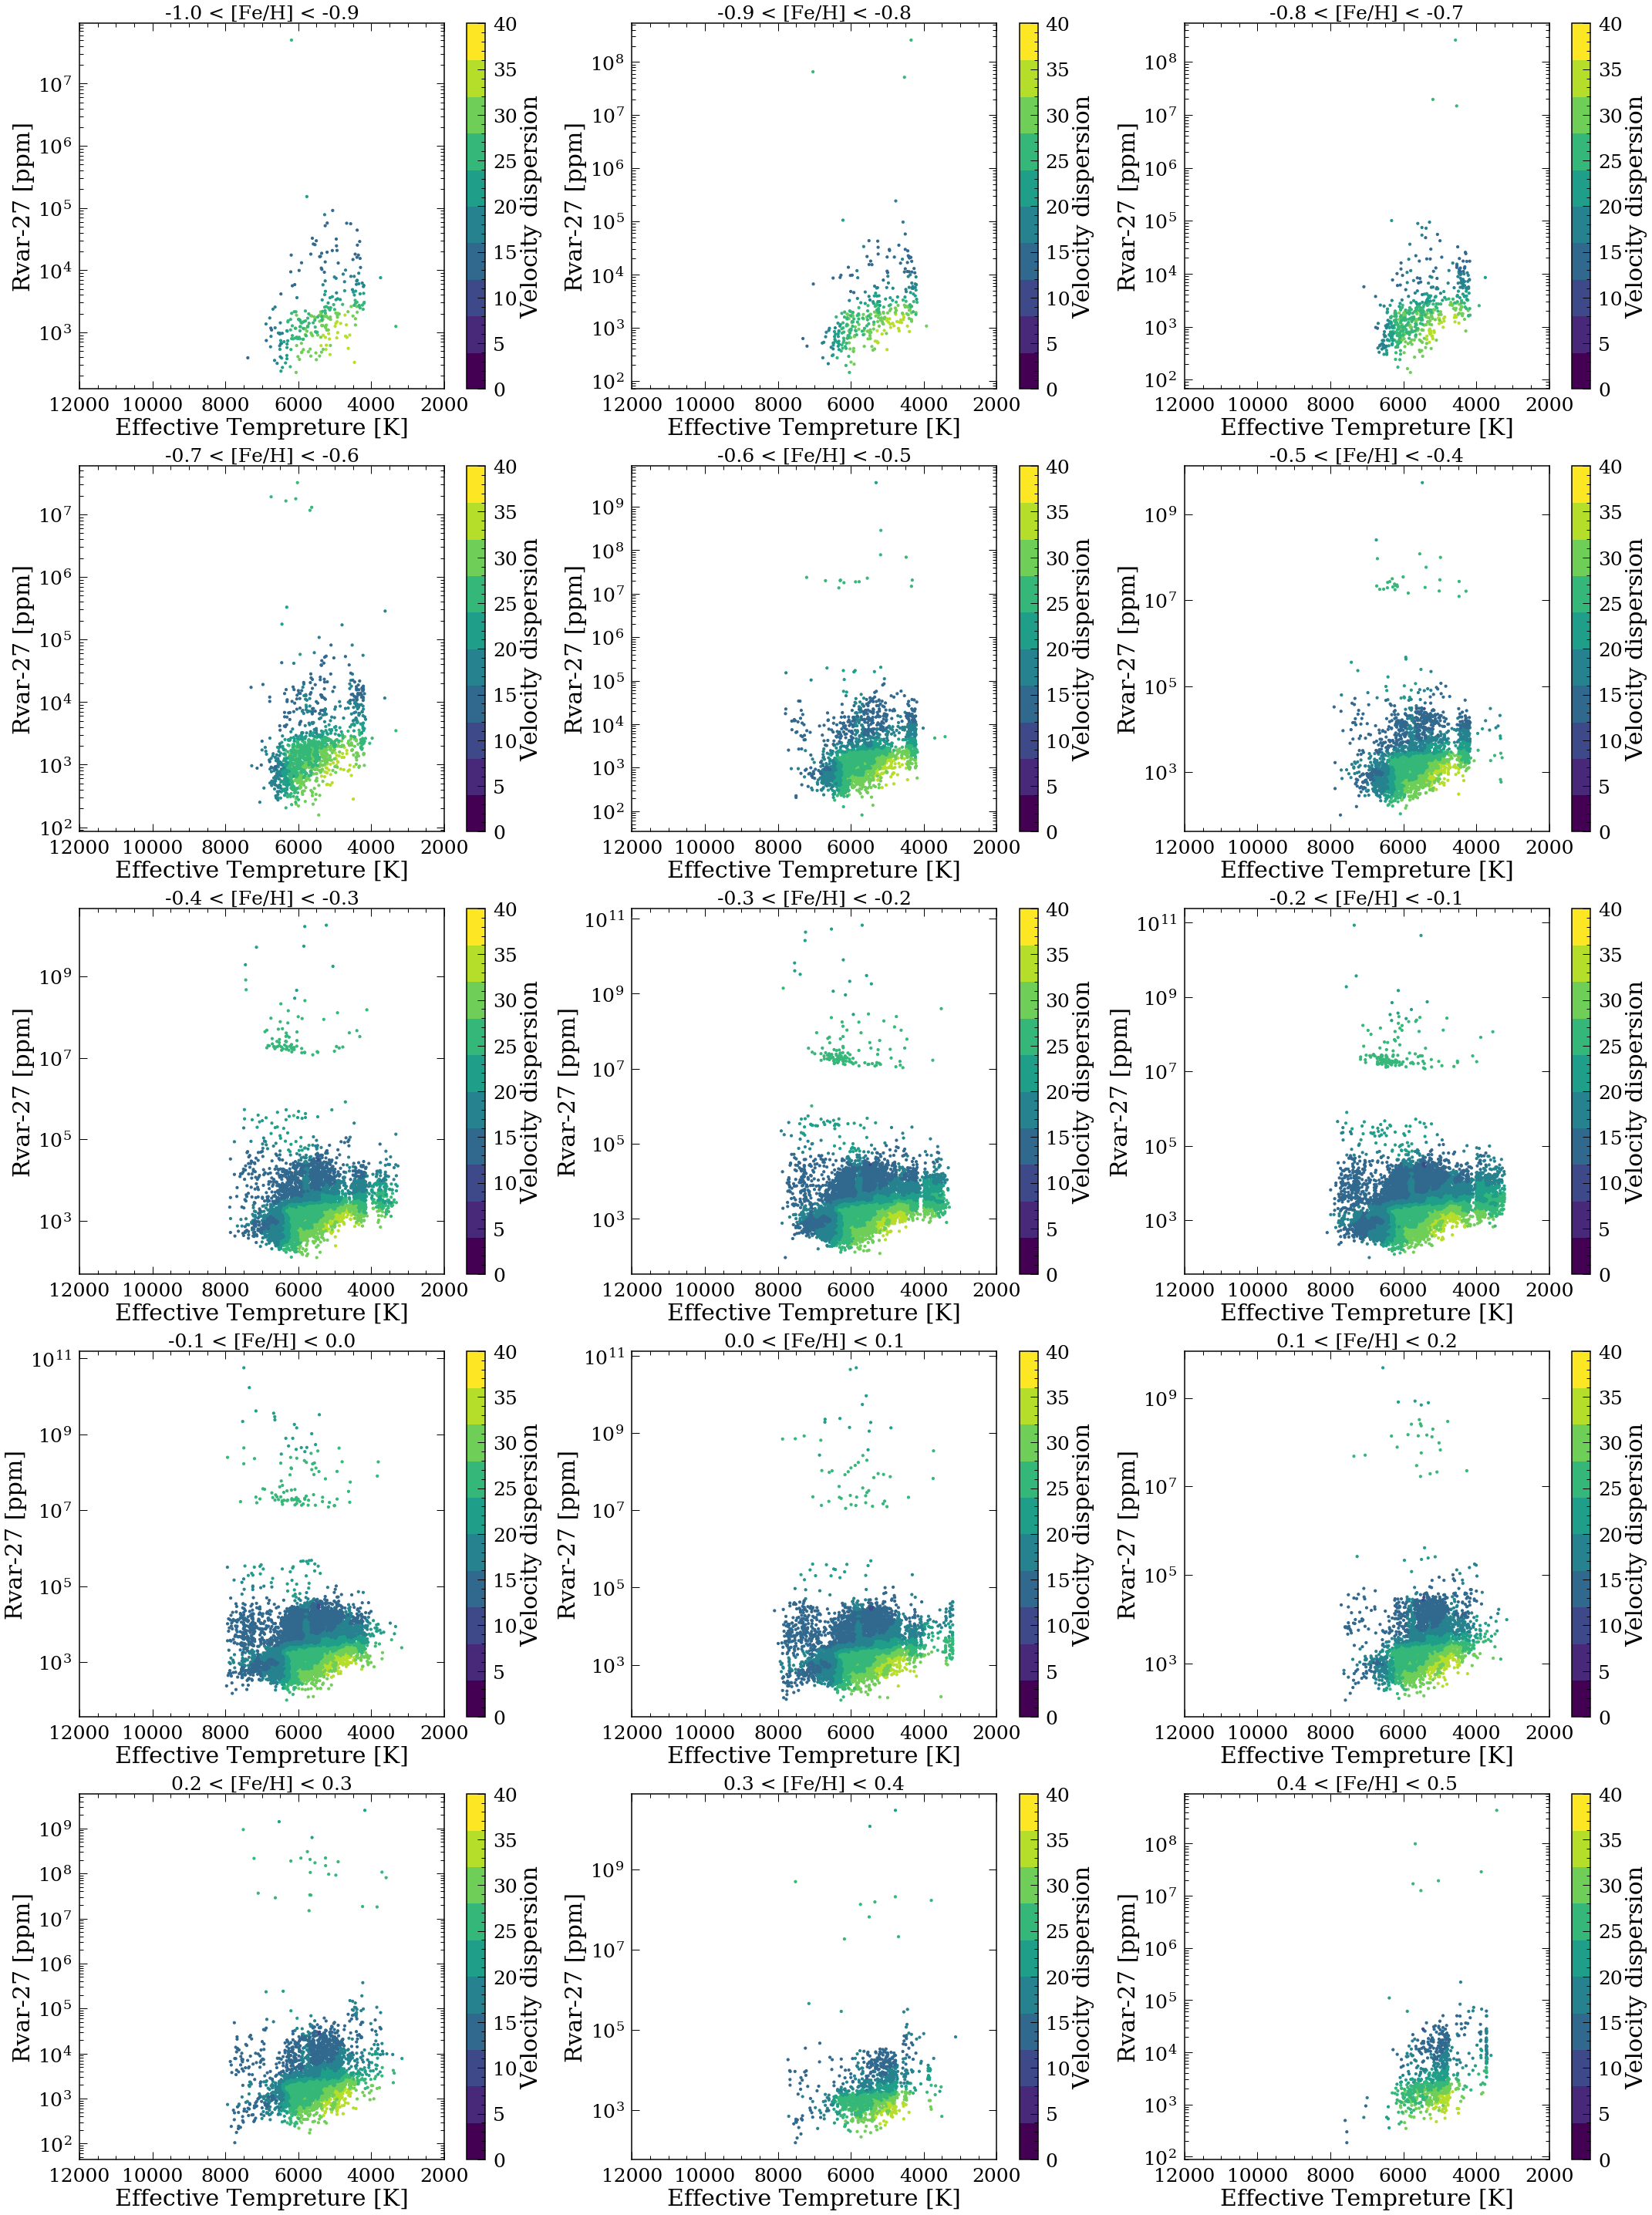

In [27]:
# plot tempreture vs Prot
cm = plt.cm.get_cmap('viridis',10)
#df=df.dropna(subset=['dv'])
df_plotdv=df_Rvar[['teff','Rvars_27','dv','feh']].sort_values(by=['dv'], ascending=False).loc[df_Rvar['kmag']<16.]
df_plotdv=df_plotdv.dropna(subset=['feh'])

diff=0.1
N=int(1.5/diff)
maxC=5
maxR=3

plt.figure(figsize=(maxR*10,maxC*8))
for i in range(N):
    plt.subplot(maxC,maxR,i+1)
    df_plotdv_fe=df_plotdv.loc[df_plotdv['feh']>-1.+diff*i]
    df_plotdv_fe=df_plotdv_fe.loc[df_plotdv['feh']<(-1.+diff)+diff*i]

    plt.scatter(df_plotdv_fe['teff'],df_plotdv_fe['Rvars_27']*1e6,c=df_plotdv_fe['dv'],s=10,vmin=0,vmax=40, cmap=cm,edgecolors=None)
    plt.title('%.1f < [Fe/H] < %.1f'%(-1.+diff*i,-1.+diff+diff*i),fontsize=25)
    plt.xlabel('Effective Tempreture [K]')
    plt.gca().invert_xaxis()
    plt.ylabel('Rvar-27 [ppm]')
    plt.yscale('log')
    plt.xlim([12000,2000])
    cb=plt.colorbar()
    cb.set_label('Velocity dispersion')
plt.tight_layout()
plt.savefig('500Rvar_sliceFeH_Cutgiant.png')


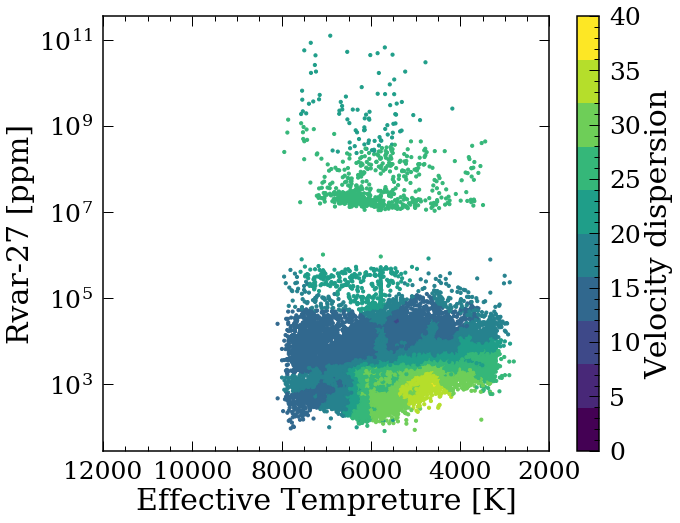

In [220]:
plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',10)
plt.scatter(noProt['teff'],noProt['Rvars_27']*1e6,c=noProt['dv_Rvar'],s=10,vmin=0,vmax=40, cmap=cm,edgecolors=None)
plt.xlabel('Effective Tempreture [K]')
plt.gca().invert_xaxis()
plt.ylabel('Rvar-27 [ppm]')
plt.yscale('log')
plt.xlim([12000,2000])
cb=plt.colorbar()
cb.set_label('Velocity dispersion')
#plt.savefig('500Rvar_Cutgiant.png')

### for giants

Text(0, 0.5, 'abs_g')

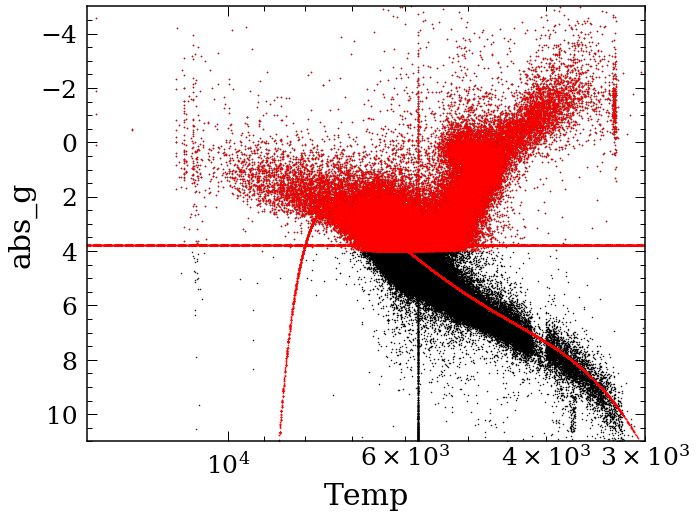

In [458]:
# cut out giants
df_nProt["abs_G"] = m_to_M(df_nProt.phot_g_mean_mag.values, 1./df_nProt.parallax.values)
df_nProt=df_nProt.dropna(subset=["abs_G"])

plt.figure(figsize=(10,8))
plt.semilogx(df_nProt['teff'],df_nProt['abs_G'],'k.',markersize=1)
plt.semilogx(df_nProt['teff'],p(df_nProt['teff'])-0.2,'r.',markersize=1)
plt.plot(df_nProt['teff'],4*np.ones(len(df_nProt['teff']))-0.2,'r--')

#df_Rvar=df_nProt.loc[df_nProt['abs_G']<p(df_nProt['teff'])-0.2]
df_Rvar_giants=df_nProt.loc[df_nProt["abs_G"]<4]
plt.semilogx(df_Rvar_giants['teff'],df_Rvar_giants['abs_G'],'r.',markersize=1)
plt.ylim([-5,11])
plt.xlim([3e3,1.5e4])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

Nstars=len(df_Rvar_giants)

plt.xlabel('Temp')
plt.ylabel('abs_g')

In [460]:
NN=500 # how many nearest to find
for i in range(Nstars):
    update_progress(i/Nstars)
    teff = df_Rvar_giants.iloc[i]['teff_norm']
    Prot = df_Rvar_giants.iloc[i]['Rvars_27_norm']
    df_Rvar_giants['dist'] = np.sqrt(np.power(df_Rvar_giants['teff_norm']-teff,2.)+np.power(df_Rvar_giants['Rvars_27_norm']-Prot,2.))
    # get the clossest stars v_b
    NNstars=df_Rvar_giants.loc[df_Rvar_giants.sort_values(by=['dist']).iloc[0:NN].index]
    
    MAD=sum(abs(NNstars['v_b']-np.median(NNstars['v_b'])))/float(len(NNstars))
    #print(MAD)
    df_Rvar_giants['dv'].iloc[i]=1.5*MAD
    

Progress: [####################] 100.0%


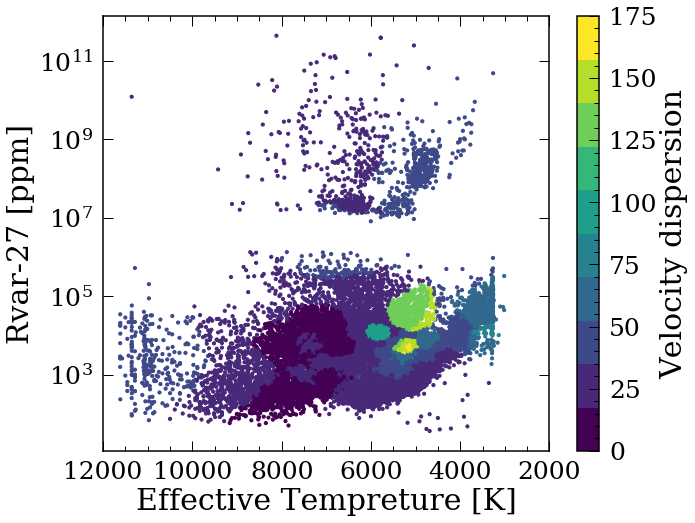

In [466]:
plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',10)
plt.scatter(df_Rvar_giants['teff'],df_Rvar_giants['Rvars_27']*1e6,c=df_Rvar_giants['dv'],s=10,vmin=0,vmax=175, cmap=cm,edgecolors=None)
plt.xlabel('Effective Tempreture [K]')
plt.gca().invert_xaxis()
plt.ylabel('Rvar-27 [ppm]')
plt.yscale('log')
plt.xlim([12000,2000])
cb=plt.colorbar()
cb.set_label('Velocity dispersion')
plt.savefig('500Rvar_giant.png')

In [ ]:
#df_nProt.to_pickle('RvarVD.pkl')

In [ ]:
#df.to_pickle('ProtVP.pkl')

# Use age-velocity dispersion to get age

Text(0.5, 1.0, '|z|>270')

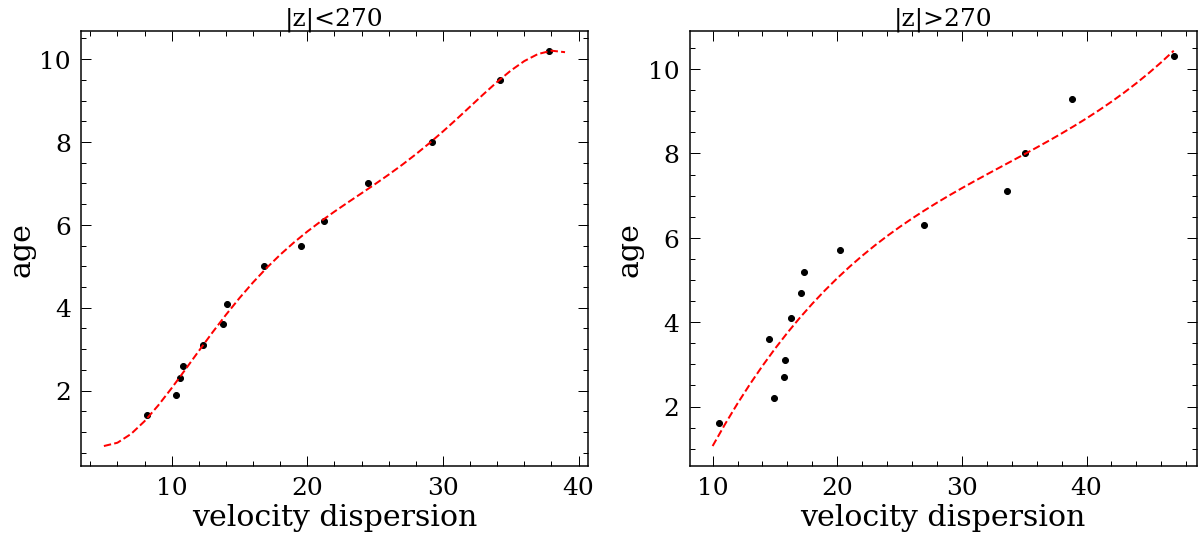

In [476]:
dv_lowz=[8.2,10.3,10.6,10.8,12.3,13.8,14.1,16.8,19.5,21.2,24.5,29.2,34.2,37.8]
age_lowz=[1.4,1.9,2.3,2.6,3.1,3.6,4.1,5.,5.5,6.1,7.0,8.,9.5,10.2]


z_lowz = np.polyfit(dv_lowz, age_lowz, 5)
p_lowz = np.poly1d(z_lowz)
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(dv_lowz,age_lowz,'ko')
plt.plot(range(5,40),p_lowz(range(5,40)),'r--')
plt.xlabel('velocity dispersion')
plt.ylabel('age')
plt.title('|z|<270',fontsize=25)

dv_hiz=[10.5,14.9,15.7,15.8,14.5,16.3,17.1,17.3,20.2,27.,33.6,35.1,38.8,47]
age_hiz=[1.6,2.2,2.7,3.1,3.6,4.1,4.7,5.2,5.7,6.3,7.1,8.,9.3,10.3]

z_hiz = np.polyfit(dv_hiz, age_hiz, 3)
p_hiz = np.poly1d(z_hiz)
plt.subplot(1,2,2)
plt.plot(dv_hiz,age_hiz,'ko')
plt.plot(range(10,48),p_hiz(range(10,48)),'r--')
plt.xlabel('velocity dispersion')
plt.ylabel('age')
plt.title('|z|>270',fontsize=25)

In [477]:
p_hiz(12.3)
#df_w=pd.read_pickle('ProtVP_cutgiant.pkl')

2.2133822772345484

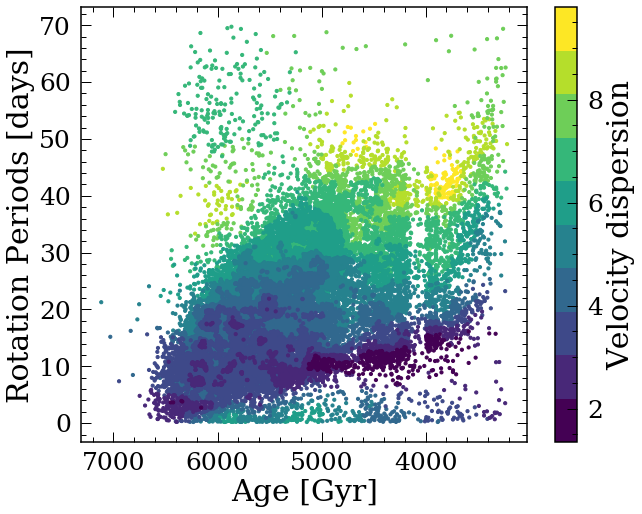

In [562]:
df_w['age_Prot']=p_lowz(df_w['dv'])
df_w_giants['age_Prot']=p_lowz(df_w_giants['dv'])

# plot tempreture vs Prot
cm = plt.cm.get_cmap('viridis',10)
plt.figure(figsize=(10,8))
df_w=df_w.dropna(subset=['dv'])
df_plotdv=df_w[['teff','Prot','age_Prot','abs_G']].sort_values(by=['age_Prot'], ascending=False).loc[df_w['kmag']<16.]
plt.scatter(df_plotdv['teff'],df_plotdv['Prot'],c=df_plotdv['age_Prot'],s=10,cmap=cm,edgecolors=None)

plt.xlabel('Age [Gyr]')
plt.gca().invert_xaxis()
plt.ylabel('Rotation Periods [days]')

cb=plt.colorbar()
cb.set_label('Velocity dispersion')

plt.savefig('150stars_wogiant_age.png')
#df_w.to_pickle('ProtVP_cutgiant.pkl')


# Train astraea on everything and predict velocity dispersion

## on ones with Prot

In [41]:
df_w=pd.read_pickle('ProtVP_cutgiant.pkl')
print(df_w.KID)

1         1026146
2         1026474
4         1164102
5         1292688
6         1297303
           ...   
32918    12884566
32919    12884589
32922    12934465
32923    12934525
32925    12984138
Name: KID, Length: 23609, dtype: int64


In [42]:
df_w=df_w.select_dtypes(include=['float64','int64'])
print(len(df_w.columns))
Tranf=df_w.drop(['dv'],axis=1).columns
print(len(Tranf))
regr, regr_outs = Astraea.RFregressor(df_w, Tranf,target_var='dv',ID_on='KID')


141
140
Simpliest example:
 regr,regr_outs = RFregressor(df,testF)

Fraction of data used to train: 0.8
# of Features attempt to train: 140
Features attempt to train: Index(['KID', 'Teff', 'logg_x', 'Mass', 'Prot', 'Prot_err', 'Rper', 'LPH', 'w',
       'DC',
       ...
       'jmag', 'hmag', 'kmag', 'kepler_gaia_ang_dist', 'v_t', 'v_b',
       'teff_norm', 'Prot_norm', 'abs_G', 'dist'],
      dtype='object', length=140)
23609 stars in dataframe!
Missing features: ['radial_velocity', 'radial_velocity_error', 'rv_template_teff', 'rv_template_logg', 'rv_template_fe_h']
Missing 3060 stars from null values in data!

20549 total stars used for RF!
16439 training stars!
Finished training! Making predictions!
Finished predicting! Calculating statistics!
Median Relative Error is: 0.008088758949021797
Average chi^2 is: 0.9917381923912613
Finished!


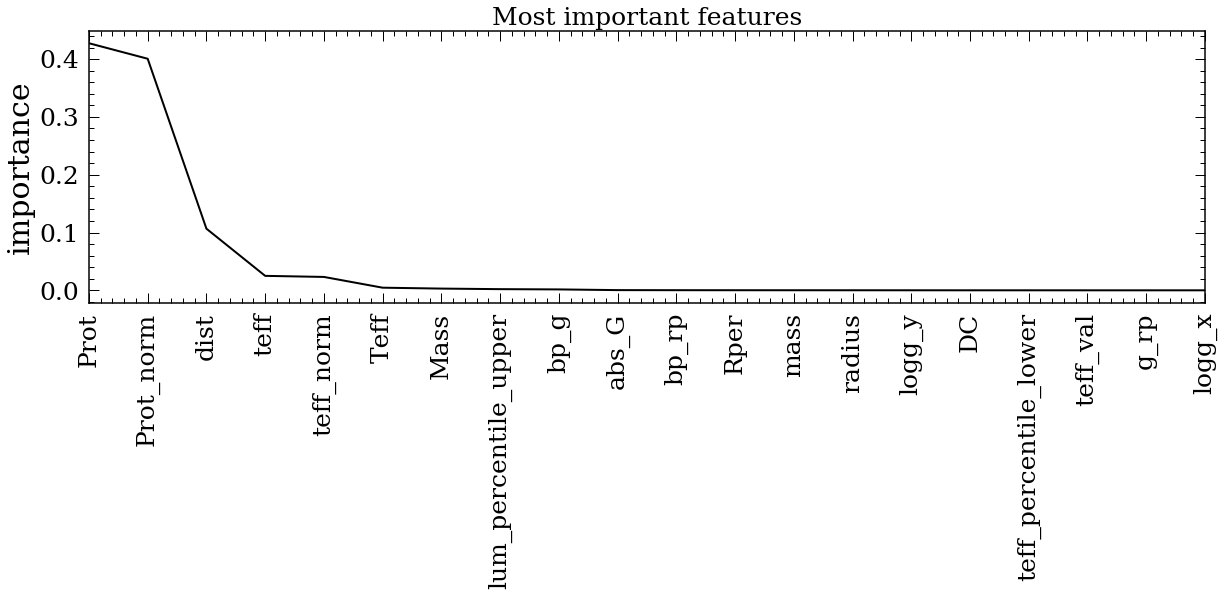

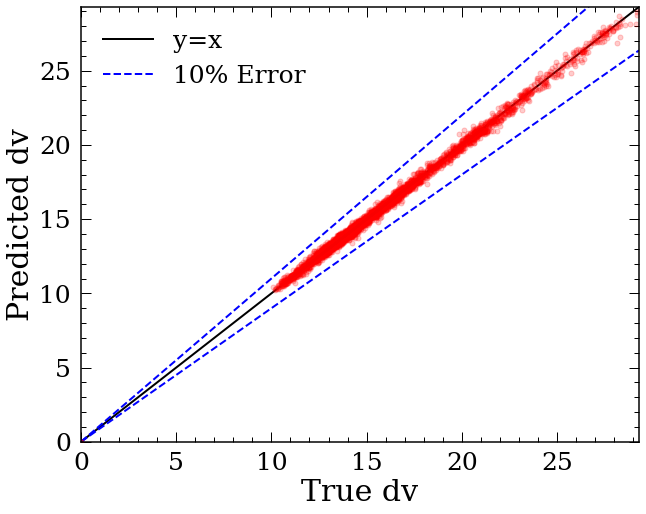

In [43]:
Astraea.plot_result(regr_outs['actrualF'], regr_outs['importance'], regr_outs['prediction'],
                    regr_outs['y_test'], labelName='dv', MS=10)

## on ones with Prot but train without Prot

In [ ]:
###### df_w=df_w.select_dtypes(include=['float64','int64'])
print(len(df_w.columns))
Tranf=df_w.drop(['dv','Prot_norm','Prot','Prot_err'],axis=1).columns
print(len(Tranf))
regr, regr_outs = Astraea.RFregressor(df_w, Tranf,target_var='dv',ID_on='KID')



In [ ]:
Astraea.plot_result(regr_outs['actrualF'], regr_outs['importance'], regr_outs['prediction'],
                    regr_outs['y_test'], labelName='dv', MS=10)

In [46]:
## on ones without Prot

In [47]:
df_noProt=pd.read_pickle('RvarVD.pkl')
df_noProt=df_noProt.select_dtypes(include=['float64','int64'])
print(len(df_noProt.columns))
Tranf=df_noProt.drop(['dv','teff_norm'],axis=1).columns
print(len(Tranf))
regr, regr_outs = Astraea.RFregressor(df_noProt, Tranf,target_var='dv',target_var_err='parallax_pmdec_corr',ID_on='KIDs')




135
133
Simpliest example:
 regr,regr_outs = RFregressor(df,testF)

Fraction of data used to train: 0.8
# of Features attempt to train: 133
Features attempt to train: Index(['solution_id', 'source_id', 'random_index', 'gaia_ref_epoch', 'ra',
       'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error',
       ...
       'kepler_gaia_ang_dist', 'v_t', 'v_b', 'KIDs', 'Rvars_27',
       'LG_period_27', 'LG_peaks_27', 'Rvars_27_log', 'Rvars_27_norm', 'dist'],
      dtype='object', length=133)
192629 stars in dataframe!
Missing features: ['radial_velocity', 'radial_velocity_error', 'rv_template_teff', 'rv_template_logg', 'rv_template_fe_h', 'a_g_val', 'a_g_percentile_lower', 'a_g_percentile_upper', 'e_bp_min_rp_val', 'e_bp_min_rp_percentile_lower', 'e_bp_min_rp_percentile_upper']
Missing 14337 stars from null values in data!

178292 total stars used for RF!
142633 training stars!
Finished training! Making predictions!
Finished predicting! Calculating statistics!
Median Relative Error

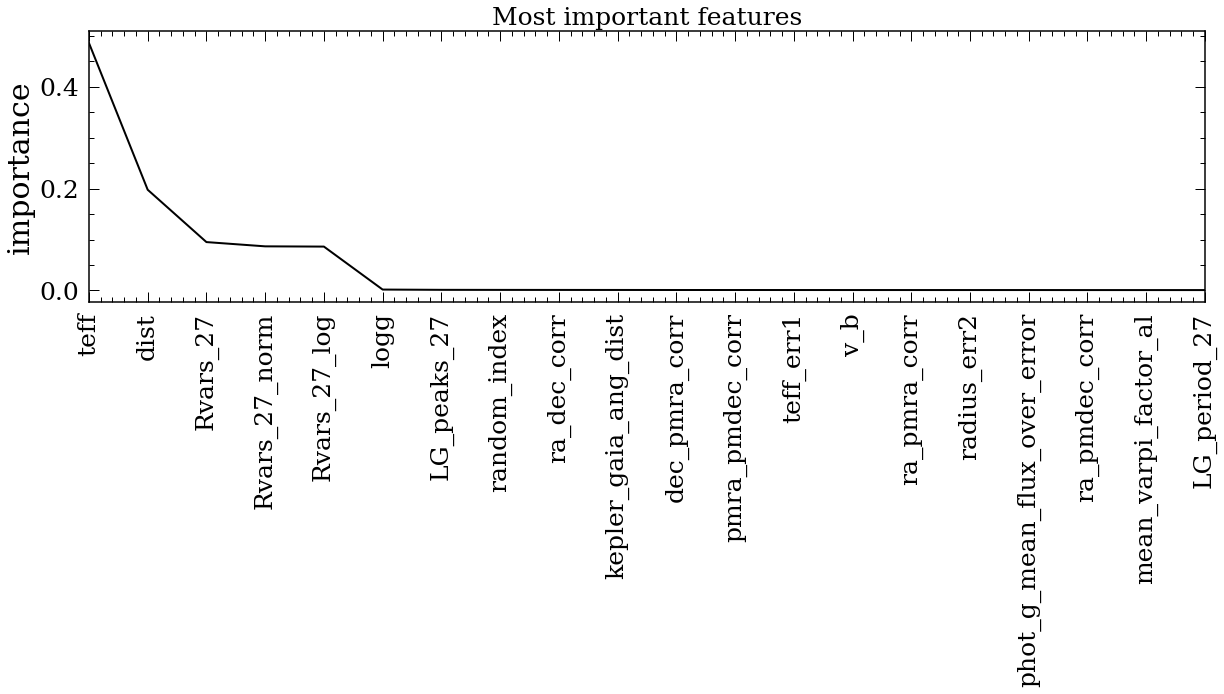

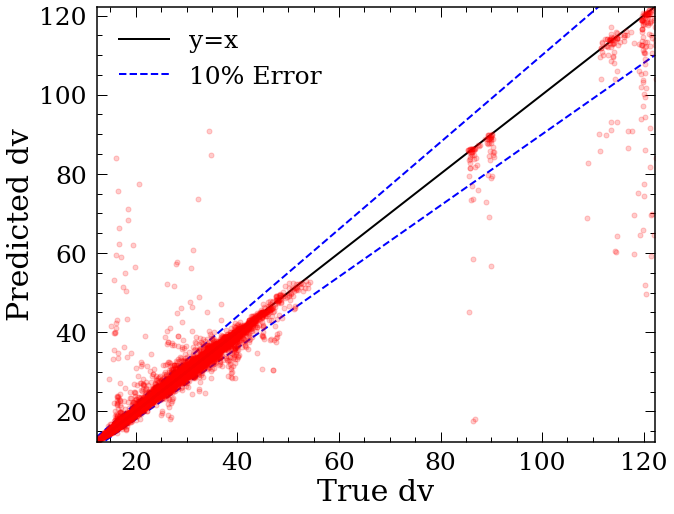

In [48]:
Astraea.plot_result(regr_outs['actrualF'], regr_outs['importance'], regr_outs['prediction'],
                    regr_outs['y_test'], labelName='dv', MS=10)

# Compare ages predcited from Rvar and Prot space

In [225]:
df_w

KID  Teff  logg_x    Mass    Prot  Prot_err      Rper    LPH  \
1       1026146  4261    4.57  0.6472  14.891     0.120  11742.56  1.405   
2       1026474  4122    4.56  0.5914   1.569     0.006  30471.80  1.204   
4       1164102  4045    4.62  0.5606  31.496     0.474   5139.74  0.568   
5       1292688  3774    4.74  0.4550  42.659     2.131   6320.15  0.530   
6       1297303  4296    4.61  0.6613  27.333     0.193   6189.53  0.777   
...         ...   ...     ...     ...     ...       ...       ...    ...   
32918  12884566  5416    4.74  0.9424  23.740     0.450   4299.88  0.593   
32919  12884589  5863    4.58  1.0660  10.589     0.027  14634.70  1.040   
32922  12934465  4714    4.88  0.7591  34.910     1.692   4572.33  0.433   
32923  12934525  5278    4.72  0.9062  25.101     0.240   5150.14  0.573   
32925  12984138  4960    4.57  0.8239  12.059     0.038  11734.90  1.194   

            w  DC  ...        v_t        v_b teff_norm  Prot_norm    dv_Prot  \
1      0.7229   0  ...  11.256302   2.149538 -1.261817  -0.265462  14.071825   
2      0.6061   0  ...  17.702679  15.602643 -1.449594  -1.508026  15.394211   
4      0.3939   0  ...  17.989548  13.596025 -1.545452   1.283312  24.867960   
5      0.3172   1  ...  43.054099 -14.155903 -2.106156   2.324503  35.364302   
6      0.5124   0  ...  22.581097  16.651520 -1.219797   0.895023  19.891699   
...       ...  ..  ...        ...        ...       ...        ...        ...   
32918  0.4161   0  ...  25.883677   9.732603  0.304740   0.559898  17.615385   
32919  0.6449   0  ...  24.194717   3.793384  1.007262  -0.666716  14.814613   
32922  0.2969   0  ...  64.961322   8.648168 -0.687982   1.601741  22.940756   
32923  0.4144   0  ...  59.579629  -1.165221  0.140600   0.686841  15.876507   
32925  0.6442   0  ...   3.918576  -0.407244 -0.332125  -0.529607  11.720014   

           abs_G      dist  age_Prot    dv_Prot       age  
1      23.111258  0.966488  3.718527  13.739251  3.718527  
2      22.595345  1.485274  4.076260  14.604661  4.076260  
4      22.570792  2.181476  6.517504  22.886604  6.517504  
5      23.599282  3.360525  8.939649  32.284743  8.939649  
6      22.055224  1.678550  6.158829  21.306969  6.158829  
...          ...       ...       ...        ...       ...  
32918  20.279711  1.261990  5.227336  17.833164  5.227336  
32919  19.635423  1.346386  2.903571  11.885299  2.903571  
32922  21.390409  2.160852  6.737505  23.886615  6.737505  
32923  20.653648  1.305072  5.066331  17.325096  5.066331  
32925  20.892401  0.000000  2.760518  11.568260  2.760518  

[23609 rows x 155 columns]

In [21]:
#noProt=pd.read_pickle('RvarVD.pkl')
noProt=pd.read_pickle('RvarVP_cutgiant.pkl')
Prot=pd.read_pickle('ProtVP_cutgiant.pkl')
#Prot=np.copy(df_w)

noProt['age_Rvar']=p_lowz(noProt['dv'])
Prot['age_Prot']=p_lowz(Prot['dv'])

noProt.rename(columns={"dv": "dv_Rvar"}, inplace = True)
Prot.rename(columns={"dv": "dv_Prot"}, inplace = True)

CM=pd.merge(noProt,Prot,left_on='kepid',right_on='kepid',how='inner')


[[1.         0.52570726]
 [0.52570726 1.        ]]


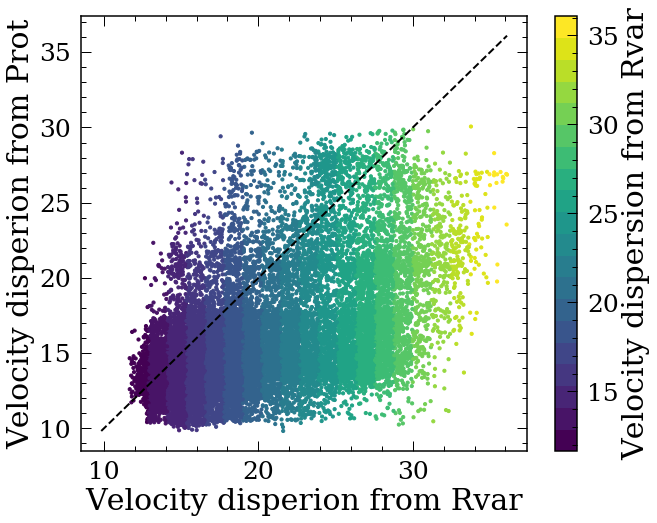

In [174]:
plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',20)
plt.scatter(CM["dv_Rvar"],CM['dv_Prot'],c=CM['dv_Rvar'],s=10,cmap=cm,edgecolors=None)
cb=plt.colorbar()
cb.set_label('Velocity dispersion from Rvar')
plt.plot([min(min(CM["dv_Rvar"]),min(CM["dv_Prot"])),max(max(CM["dv_Rvar"]),max(CM["dv_Prot"]))],[min(min(CM["dv_Rvar"]),min(CM["dv_Prot"])),max(max(CM["dv_Rvar"]),max(CM["dv_Prot"]))],'k--')
plt.xlabel('Velocity disperion from Rvar')
plt.ylabel('Velocity disperion from Prot')
r = np.corrcoef(CM["dv_Rvar"], CM['dv_Prot'])
#plt.savefig('ProtRvar.png')
print(r)

Train to see if I can get VD for Prot

Simpliest example:
 regr,regr_outs = RFregressor(df,testF)

Fraction of data used to train: 0.8
# of Features attempt to train: 9
Features attempt to train: ['teff_norm_y', 'mass_y', 'bp_rp_y', 'dv_Rvar', 'parallax_x', 'logg', 'radius_x', 'v_t_x', 'v_b_x']
23606 stars in dataframe!
Missing 45 stars from null values in data!

23561 total stars used for RF!
18848 training stars!
Finished training! Making predictions!
Finished predicting! Calculating statistics!
Median Relative Error is: 0.07095307783046387
Average chi^2 is: 0.3210089369683966
Finished!


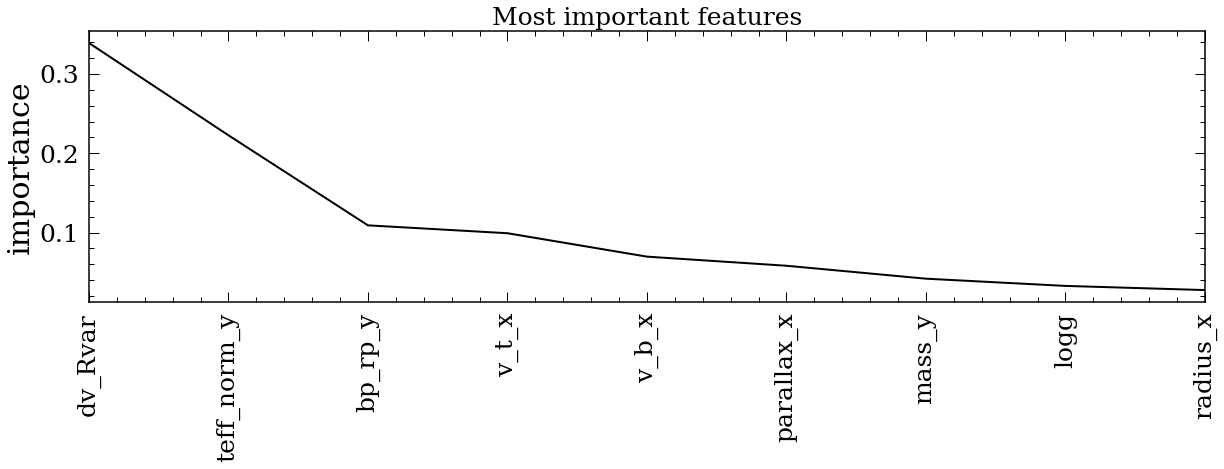

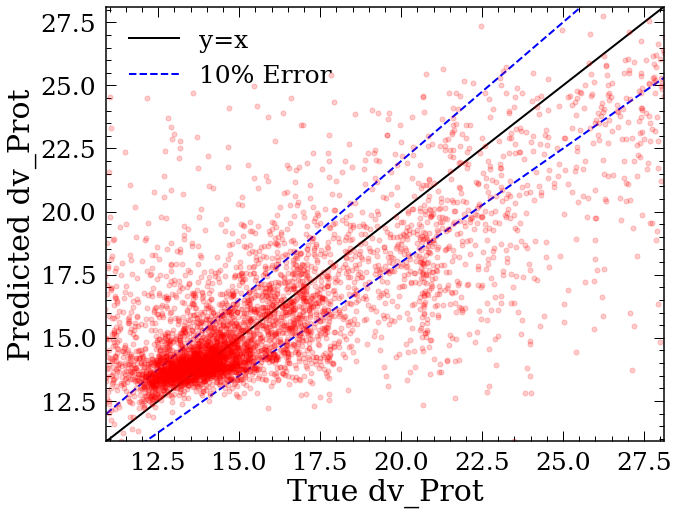

In [207]:
TranF=['teff_norm_y','mass_y','bp_rp_y','dv_Rvar','parallax_x','logg','radius_x','v_t_x','v_b_x']
regr, regr_outs = Astraea.RFregressor(CM, TranF,target_var='dv_Prot',target_var_err='dv_Rvar')

Astraea.plot_result(regr_outs['actrualF'], regr_outs['importance'], regr_outs['prediction'],
                    regr_outs['y_test'], labelName='dv_Prot', MS=10)



Text(0, 0.5, 'Age from Prot')

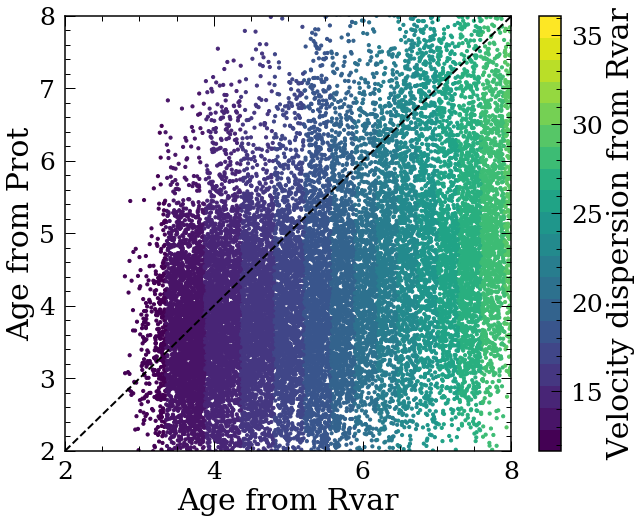

In [175]:
plt.figure(figsize=(10,8))
#plt.plot(CM["age_Rvar"],CM['age_Prot'],'r.',alpha=0.5)
plt.scatter(CM["age_Rvar"],CM['age_Prot'],c=CM['dv_Rvar'],s=10,cmap=cm,edgecolors=None)
cb=plt.colorbar()
cb.set_label('Velocity dispersion from Rvar')

plt.plot([2,8],[2,8],'k--')
plt.xlim([2,8])
plt.ylim([2,8])
plt.xlabel('Age from Rvar')
plt.ylabel('Age from Prot')



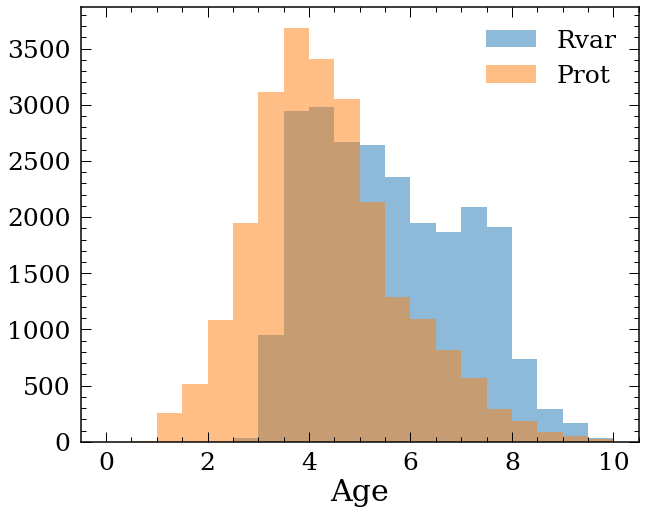

In [176]:
plt.figure(figsize=(10,8))
plt.hist(CM["age_Rvar"],bins=[i*0.5 for i in range(21)],label='Rvar',alpha=0.5)
plt.hist(CM["age_Prot"],bins=[i*0.5 for i in range(21)],label='Prot',alpha=0.5)
plt.xlabel('Age')
plt.legend()

# Check with NGC6811

In [119]:
NGC=pd.read_table('https://iopscience.iop.org/2041-8205/733/1/L9/suppdata/apjl390631t1_mrt.txt',skiprows=36,delim_whitespace=True,names=['ID','RAh','RAm','RAs','DEd','DEm','DEs','gmag','rmag','Period','e_Period','o_Period','Class'])
NGC

ID  RAh  RAm    RAs  DEd  DEm    DEs   gmag   rmag  Period  e_Period  \
0   9715923   19   36  39.33   46   27   1.83  13.62  13.36    0.92      0.01   
1   9594100   19   36  55.98   46   15  18.47  13.22  12.95    0.96      0.01   
2   9716563   19   37  38.57   46   29  12.68  13.92  13.57    1.29      0.21   
3   9716817   19   37  59.91   46   24  44.75  14.55  14.14    1.36      0.01   
4   9654924   19   36  41.17   46   23   9.52  13.94  13.65    1.60      0.22   
..      ...  ...  ...    ...  ...  ...    ...    ...    ...     ...       ...   
66  9838215   19   38  55.22   46   37  18.81  16.09  15.53   11.77      0.25   
67  9716177   19   37   2.36   46   24  55.94  16.62  15.96   11.92      0.40   
68  9655435   19   37  24.91   46   22  16.17  16.71  15.98   11.99      0.31   
69  9595724   19   39  17.31   46   17  38.33  14.95  14.48   12.66      0.32   
70  9717386   19   38  50.46   46   27  11.59  16.56  15.94   16.40      1.47   

    o_Period Class  
0          5   CSM  
1          6   CSM  
2          4    SM  
3          4    SM  
4          4   CSM  
..       ...   ...  
66         4   CSM  
67         2   CSM  
68         5    CM  
69         3   CSM  
70         3   CSM  

[71 rows x 13 columns]

In [177]:
NGC_cm=pd.merge(CM,NGC,left_on='KID',right_on='ID',how='inner')


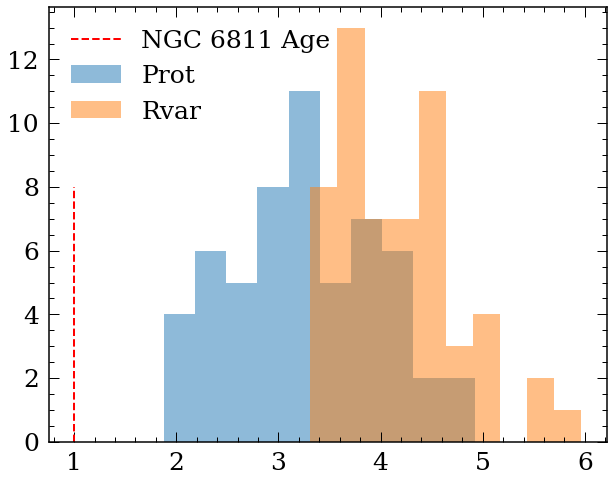

In [178]:
plt.figure(figsize=(10,8))
plt.hist(NGC_cm["age_Prot"],bins=10,label='Prot',alpha=0.5)
plt.hist(NGC_cm["age_Rvar"],bins=10,label='Rvar',alpha=0.5)
plt.plot([1,1],[0,8],'r--',label='NGC 6811 Age')
plt.legend(loc='upper left')
#plt.savefig('checkage.png')

In [161]:
Clusters=pd.read_table('/Users/lucy/Desktop/KeplerAges/Cluster.csv.webarchive',delimiter=',',skiprows=1)
Clusters.columns.values[0]='RA_ICRS'
Clusters=Clusters.dropna(subset=['DE_ICRS'])
Clusters

0         5.149786e+16
1         5.155896e+16
2         5.161627e+16
3         5.161912e+16
4         5.167767e+16
              ...     
435828    6.913212e+18
435829    6.913215e+18
435830    6.913592e+18
435831    6.913598e+18
435832    6.913624e+18
Name: Source, Length: 435833, dtype: float64

In [164]:
Clusters_cm=pd.merge(Clusters,CM,left_on='Source',right_on='source_id_x',how='inner')
Clusters_cm['Cluster'].unique()

array(['NGC_6791', 'ASCC_108', 'NGC_6866', 'NGC_6819', 'NGC_6811'],
      dtype=object)

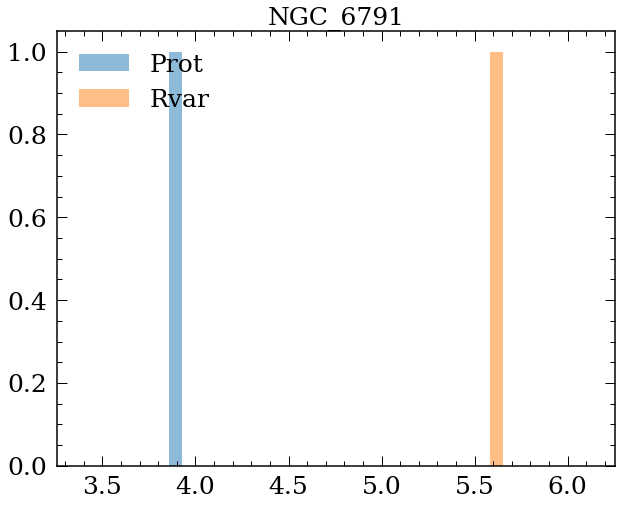

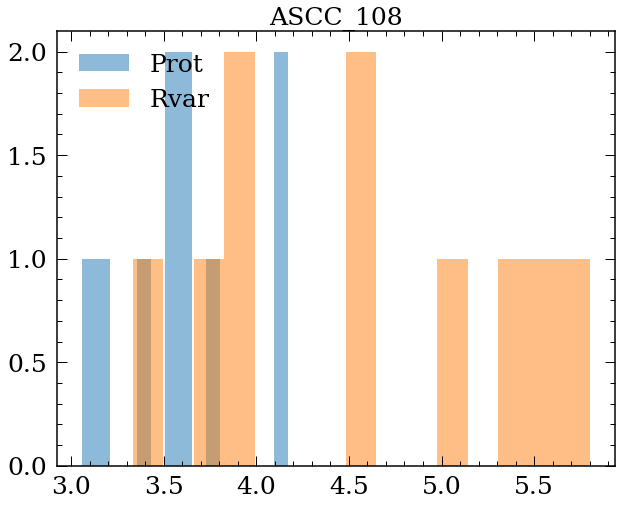

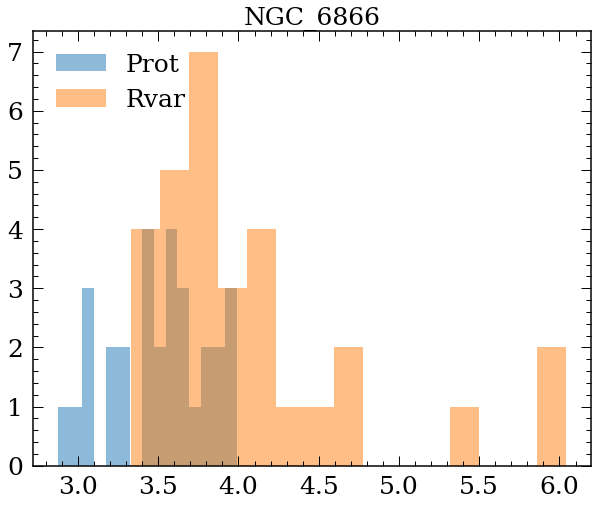

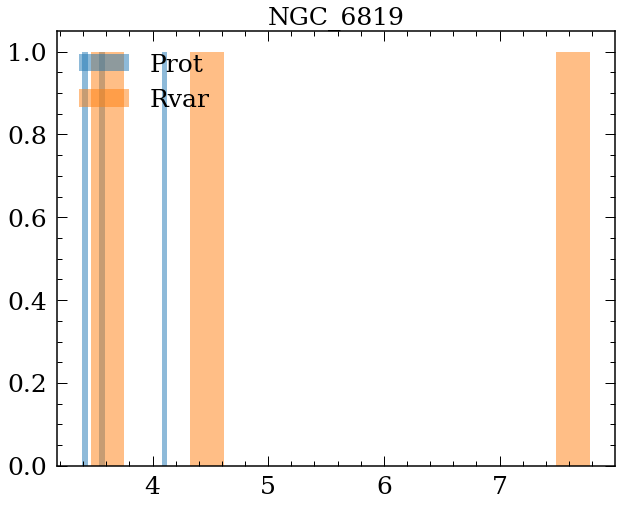

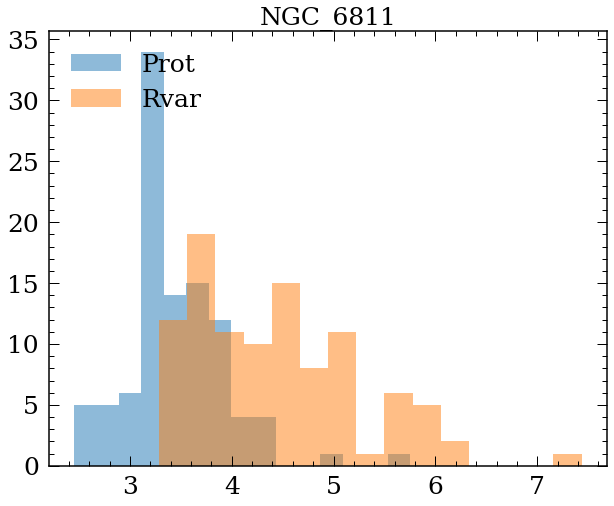

In [180]:
for cluster in Clusters_cm['Cluster'].unique():
    plotCM=Clusters_cm.loc[Clusters_cm['Cluster']==cluster]
    plt.figure(figsize=(10,8))
    plt.hist(plotCM["age_Prot"],bins=15,label='Prot',alpha=0.5)
    plt.hist(plotCM["age_Rvar"],bins=15,label='Rvar',alpha=0.5)
    plt.title(cluster,fontsize=25)
    #plt.plot([1,1],[0,8],'r--',label=cluster)
    plt.legend(loc='upper left')
    #plt.savefig('checkage.png')

# asteroseismology stars

## In Prot space

In [547]:
KID_as=[10666592,8554498, 11853905, 6521045, 8866102,
        3544595, 11904151, 5866724, 4914423, 8349582,
        5094751, 4349452, 8478994, 11295426, 8292840,
        11807274, 10514430, 3425851, 7670943, 8077137,
        10586004, 11133306, 11401755, 4141376, 4143755,
        6196457, 9592705, 8494142, 9414417, 3632418,
        10963065, 9955598, 6278762]
noProt.loc[noProt['KIDs'].isin(KID_as)]


solution_id                   designation     source_id  random_index  \
4947   1.635721e+18  Gaia DR2 2100020484108391808  2.100020e+18  2.002443e+08   
5733   1.635721e+18  Gaia DR2 2052747119115620352  2.052747e+18  1.095812e+09   
9371   1.635721e+18  Gaia DR2 2100392428275714688  2.100392e+18  5.582542e+08   
10557  1.635721e+18  Gaia DR2 2100451630105041152  2.100452e+18  1.464637e+09   
28646  1.635721e+18  Gaia DR2 2101486923385239808  2.101487e+18  1.549590e+09   
43186  1.635721e+18  Gaia DR2 2105620159389754624  2.105620e+18  1.091895e+09   
54649  1.635721e+18  Gaia DR2 2106674071344722688  2.106674e+18  1.382139e+09   
59227  1.635721e+18  Gaia DR2 2106904148451706752  2.106904e+18  1.216277e+07   
74081  1.635721e+18  Gaia DR2 2128215909315876352  2.128216e+18  1.367969e+09   
86334  1.635721e+18  Gaia DR2 2131593785132997632  2.131594e+18  2.582194e+08   
88507  1.635721e+18  Gaia DR2 2129495057954829952  2.129495e+18  1.605281e+09   

       gaia_ref_epoch          ra  ra_error        dec  dec_error   parallax  \
4947           2015.5  285.728907  0.026216  38.506900   0.029184   3.857983   
5733           2015.5  291.418127  0.019436  38.672312   0.023919  10.397381   
9371           2015.5  286.689599  0.016714  39.212080   0.021357   4.660282   
10557          2015.5  286.638391  0.019753  39.487904   0.022074   4.082242   
28646          2015.5  289.752832  0.024011  41.631884   0.026349  27.413729   
43186          2015.5  287.345674  0.021666  43.378389   0.025815   3.357786   
54649          2015.5  284.059250  0.023249  44.518373   0.028216  15.615476   
59227          2015.5  283.151045  0.018499  45.140084   0.021652   6.749535   
74081          2015.5  293.679206  0.018277  46.852734   0.022253  14.639630   
86334          2015.5  284.786216  0.029544  48.423262   0.034218  11.234578   
88507          2015.5  289.664394  0.024960  48.706165   0.031994   2.979635   

       ...     Rvars_27  LG_period_27  LG_peaks_27  Rvars_27_log  teff_norm  \
4947   ...   787.625000      0.000341     0.519433      2.896319   0.822578   
5733   ...     0.000142      0.010221     0.126537     -3.848987  -0.142342   
9371   ...   369.815625      0.000341     0.013284      2.567985   0.551455   
10557  ...   494.250000      1.581893     0.012786      2.693947   0.718300   
28646  ...  1780.250000      0.000341     8.117810      3.250481  -0.972396   
43186  ...   411.918750      0.000341     0.012476      2.614812   1.010278   
54649  ...  1822.337500      0.000341     0.539642      3.260629  -0.435711   
59227  ...  2396.000000      0.000341     0.804176      3.379487   0.912952   
74081  ...  1872.500000      0.000681     0.931499      3.272422  -0.410685   
86334  ...  1492.975000      0.000341     0.156862      3.174053   0.540332   
88507  ...   271.718750      0.000341     0.004372      2.434120   0.316481   

       Rvars_27_norm    dv_Rvar     abs_G  dist  age_Rvar  
4947       -1.219288  23.044428  3.482412   NaN  6.552373  
5733        0.660178  29.242550  4.947114   NaN  8.038247  
9371       -0.476495  23.599623  4.356117   NaN  6.674491  
10557       0.321212  23.250766  3.686344   NaN  6.597833  
28646      -2.699155  23.188298  5.833087   NaN  6.584083  
43186       0.895774  23.698754  3.495417   NaN  6.696255  
54649       1.215705  22.556674  5.517652   NaN  6.444231  
59227      -1.041717  22.408498  3.521171   NaN  6.411114  
74081       0.059550  22.971752  5.218742   NaN  6.536328  
86334       0.141965   4.658443  3.951981   NaN  0.669800  
88507       0.237596  23.574268  4.154401   NaN  6.668924  

[11 rows x 147 columns]

In [548]:
ASstars=pd.read_table('/Users/lucy/Desktop/KeplerAges/ASage.webarchive',delimiter=',',skiprows=2)
ASstars=ASstars.dropna(subset=['KIC'])
ASstars

Pipe         KIC    Mass     Rad  log(g)     Age     Lum      rho  \
0    AST      1435467.0  1.3417  1.7029  4.1028  2.6679  4.2160  0.38250   
1    AST      2837475.0  1.3879  1.6201  4.1608  1.6573  4.5620  0.45960   
2    AST      3427720.0  1.0990  1.1145  4.3844  2.3521  1.5030  1.11780   
3    AST      3456181.0  1.5569  2.1784  3.9537  1.8812  7.3170  0.21210   
4    AST      3632418.0  1.4772  1.9481  4.0279  2.4261  5.3000  0.28140   
..      ...         ...     ...     ...     ...     ...     ...      ...   
391  YMCM    12069127.0  1.5894  2.3051  3.9134  1.7595  0.8694  0.18272   
392  YMCM    12069424.0  1.0760  1.2253  4.2930  7.5242  0.1784  0.82366   
393  YMCM    12069449.0  1.0298  1.1115  4.3585  7.2215  0.0867  1.05600   
394  YMCM    12258514.0  1.2704  1.6085  4.1287  4.2362  0.4791  0.42990   
395  YMCM    12317678.0  1.3408  1.8089  4.0500  2.2406  0.7479  0.31893   

       Dist    Xini    Yini    Xsup    Ysup    Xcen    Ycen  MCcore    Rbce  \
0    137.22  0.7020  0.2780  0.7020  0.2780  0.1160  0.8640  0.0590  0.8410   
1    118.27  0.7040  0.2770  0.7040  0.2770  0.3510  0.6300  0.0710  0.9200   
2     90.93  0.7060  0.2750  0.7340  0.2490  0.4240  0.5580  0.0000  0.7720   
3    249.36  0.7010  0.2770  0.7010  0.2770  0.0490  0.9290  0.0640  0.8760   
4    109.67  0.6960  0.2770  0.6960  0.2770  0.0390  0.9340  0.0600  0.8200   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
391  427.23  0.7115  0.2669  0.7115  0.2669  0.0868  0.8915  0.1086  0.8645   
392   21.20  0.7288  0.2505  0.7288  0.2505  0.0386  0.9408  0.0000  0.7255   
393   20.95  0.7186  0.2611  0.7385  0.2426  0.1403  0.8385  0.0000  0.7117   
394   80.69  0.7306  0.2499  0.7306  0.2499  0.0466  0.9339  0.0592  0.7755   
395  142.99  0.7258  0.2640  0.7258  0.2640  0.1373  0.8525  0.0912  0.9068   

      alpha    TAMS  
0    1.8000  2.9535  
1    1.8000  2.5932  
2    1.8000  6.6391  
3    1.8000  2.0413  
4    1.8000  2.6314  
..      ...     ...  
391  1.6715  1.8826  
392  1.6738  9.0157  
393  1.7610  9.7540  
394  1.6985  4.5702  
395  1.5152  2.3824  

[396 rows x 19 columns]

In [549]:
# recalculate for these stars
KID_recalc=Clusters_cm['KIC'].unique()
NN=2 # how many nearest to find
for i in range(len(KID_recalc)):
    update_progress(i/len(KID_recalc))
    print(KID_recalc[i])
    print('before:'+str(noProt['dv_Rvar'].loc[noProt['KIDs']==KID_recalc[i]].values))
    teff = noProt.loc[noProt['KIDs']==KID_recalc[i]]['teff_norm']
    Prot = noProt.loc[noProt['KIDs']==KID_recalc[i]]['Rvars_27_norm']
    noProt['dist'] = np.sqrt(np.power(noProt['teff_norm']-teff,2.)+np.power(noProt['Rvars_27_norm']-Prot,2.))
    # get the clossest stars v_b
    NNstars=noProt.loc[noProt.sort_values(by=['dist']).iloc[0:NN].index]
    
    MAD=sum(abs(NNstars['v_b']-np.median(NNstars['v_b'])))/float(len(NNstars))

    noProt['dv_Rvar'].loc[noProt['KIDs']==KID_recalc[i]]=1.5*MAD
    print('after:'+str(noProt['dv_Rvar'].loc[noProt['KIDs']==KID_recalc[i]].values))
Agebefore=noProt['age_Rvar'].loc[noProt['KIDs'].isin(KID_recalc)]
noProt['age_Rvar']=p_lowz(noProt['dv_Rvar'])
print('Net Age change:',sum(Agebefore-noProt['age_Rvar'].loc[noProt['KIDs'].isin(KID_recalc)]))


Progress: [####################] 97.6%
12317678.0
before:[]
after:[]
Net Age change: 0.0


In [550]:
Clusters_cm=pd.merge(ASstars,df_w_giants,left_on='KIC',right_on='KID',how='inner')
#Clusters_cm=pd.merge(ASstars,noProt,left_on='KIC',right_on='KIDs',how='inner')
Clusters_cm

Pipe         KIC  Mass_x     Rad  log(g)     Age     Lum       rho  \
0       AST      5773345.0  1.5098  2.0364  3.9987  2.2791  5.3980  0.251700   
1       BASTA    5773345.0  1.4690  2.0194  3.9930  2.5533  5.3290  0.251367   
2       C2kSMO   5773345.0  1.6682  2.0985  4.0162  2.2356  5.6020  0.254300   
3       GOE      5773345.0  1.5375  2.0330  4.0084  2.1331  5.5247  0.257744   
4   V&amp;A      5773345.0  1.4800  2.0200  3.9975  3.3950  5.4990  0.252743   
..         ...         ...     ...     ...     ...     ...     ...       ...   
79      BASTA   12009504.0  1.1688  1.4016  4.2108  3.9746  2.5440  0.597379   
80      C2kSMO  12009504.0  1.1760  1.3990  4.2165  3.5789  2.5790  0.604900   
81      GOE     12009504.0  1.1456  1.3895  4.2112  3.0974  2.6433  0.601466   
82  V&amp;A     12009504.0  1.1660  1.3970  4.2127  3.6990  2.5860  0.601333   
83      YMCM    12009504.0  1.1986  1.4120  4.2165  3.9903  0.4169  0.599400   

      Dist    Xini  ...        v_t       v_b  teff_norm  Prot_norm     abs_G  \
0   183.13  0.6770  ...  27.427665 -8.733038  -0.068708  -0.132111  2.794272   
1   181.58  0.6770  ...  27.427665 -8.733038  -0.068708  -0.132111  2.794272   
2   188.72  0.6910  ...  27.427665 -8.733038  -0.068708  -0.132111  2.794272   
3   182.83  0.6501  ...  27.427665 -8.733038  -0.068708  -0.132111  2.794272   
4   181.65  0.7320  ...  27.427665 -8.733038  -0.068708  -0.132111  2.794272   
..     ...     ...  ...        ...       ...        ...        ...       ...   
79  134.25  0.7030  ...   8.563082 -6.692219   0.055220  -0.271868  3.579496   
80  134.01  0.7030  ...   8.563082 -6.692219   0.055220  -0.271868  3.579496   
81  133.10  0.6505  ...   8.563082 -6.692219   0.055220  -0.271868  3.579496   
82  133.82  0.6980  ...   8.563082 -6.692219   0.055220  -0.271868  3.579496   
83  135.26  0.7287  ...   8.563082 -6.692219   0.055220  -0.271868  3.579496   

           dv      dist  age_Prot  Rvars_27_norm  age_Rvar  
0   18.665467  0.186789  5.298861      -0.132111  5.475710  
1   18.665467  0.186789  5.298861      -0.132111  5.475710  
2   18.665467  0.186789  5.298861      -0.132111  5.475710  
3   18.665467  0.186789  5.298861      -0.132111  5.475710  
4   18.665467  0.186789  5.298861      -0.132111  5.475710  
..        ...       ...       ...            ...       ...  
79  18.020757  0.000000  5.593255      -0.271868  5.284949  
80  18.020757  0.000000  5.593255      -0.271868  5.284949  
81  18.020757  0.000000  5.593255      -0.271868  5.284949  
82  18.020757  0.000000  5.593255      -0.271868  5.284949  
83  18.020757  0.000000  5.593255      -0.271868  5.284949  

[84 rows x 172 columns]

In [551]:
Clusters_cm['Pipe'].unique()

array(['AST   ', 'BASTA ', 'C2kSMO', 'GOE   ', 'V&amp;A   ', 'YMCM  '],
      dtype=object)

In [552]:
Clusters_cm['age_Prot']

0     5.298861
1     5.298861
2     5.298861
3     5.298861
4     5.298861
        ...   
79    5.593255
80    5.593255
81    5.593255
82    5.593255
83    5.593255
Name: age_Prot, Length: 84, dtype: float64

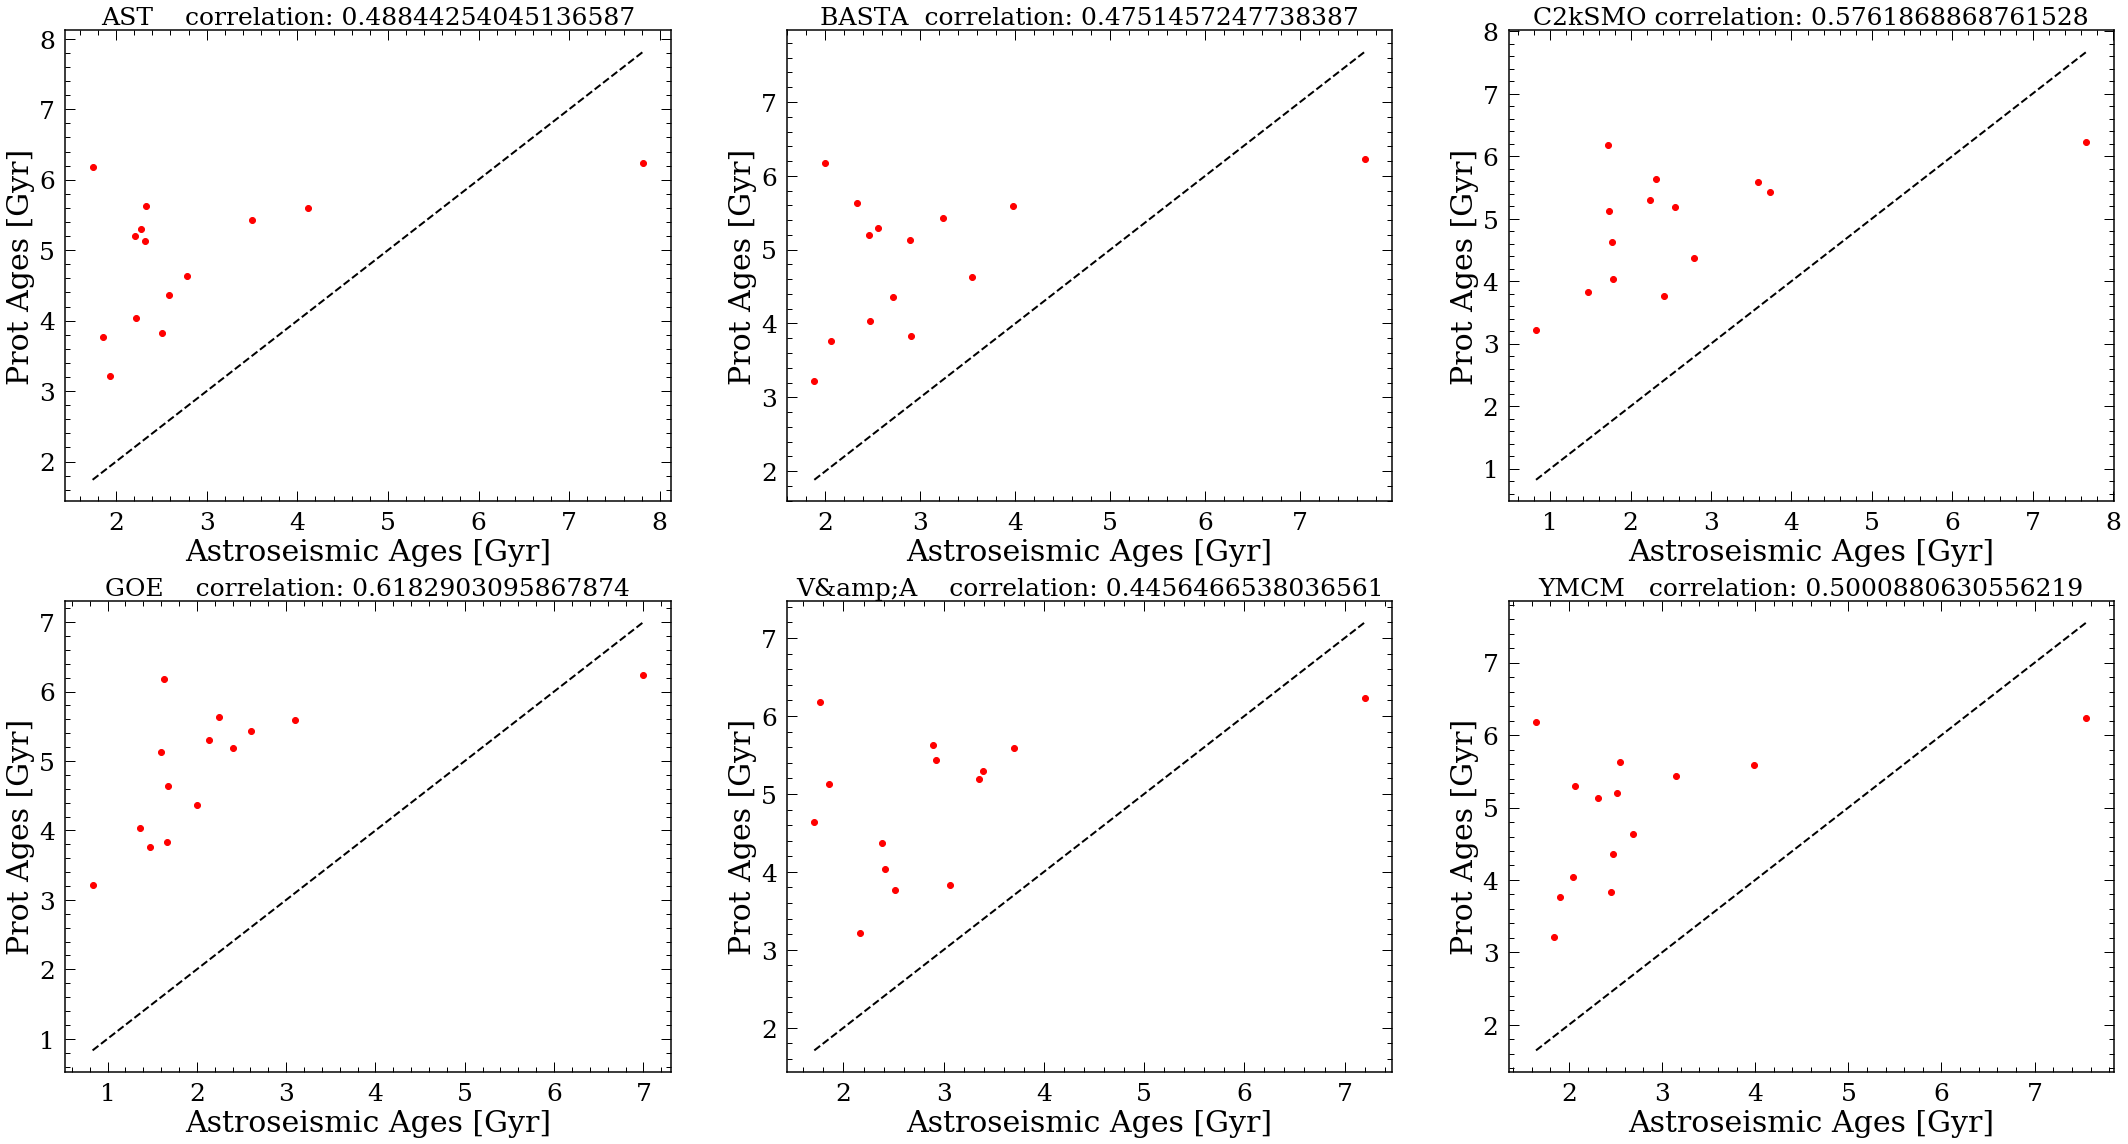

In [553]:
plt.figure(figsize=(30,16))
pcount=1
for pip in Clusters_cm['Pipe'].unique():
    plt.subplot(2,3,pcount)
    plotCM=Clusters_cm.loc[Clusters_cm['Pipe']==pip]
    #plt.plot(plotCM["Age"],plotCM["age_Prot"],'o',label='Prot Age')
    plt.plot(plotCM["Age"],plotCM["age_Prot"],'ro',label='Rvar Age')
    plt.plot([min(plotCM["Age"]),max(plotCM["Age"])],[min(plotCM["Age"]),max(plotCM["Age"])],'k--')
    
    plt.xlabel('Astroseismic Ages [Gyr]')
    plt.ylabel('Prot Ages [Gyr]')
    r = np.corrcoef(plotCM["Age"], plotCM["age_Prot"])
    plt.title(pip+' correlation: '+str(r[1][0]),fontsize=25)
    #plt.plot([1,1],[0,8],'r--',label=cluster)
    #plt.legend(loc='upper left')
    pcount=pcount+1
plt.tight_layout()
#plt.savefig('checkage.png')

Get best NN

In [554]:
xnames=[]
ynames=[]
rCorr_all=[]
rCorr_err_all=[]

before dropping 9887
after dropping 9887


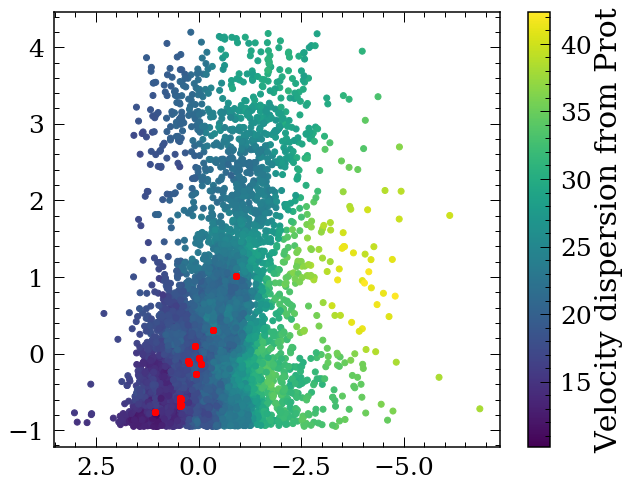

In [555]:
#noProt['Rvars_27_log']=np.log10(noProt['Rvars_27'])
xname='teff'
yname='Prot'
df_w_giants=df_w_giants.dropna(subset=[xname,yname])
X_nn = StandardScaler().fit_transform(df_w_giants[[xname,yname]])
df_w_giants['teff_norm'],df_w_giants['Prot_norm'] = X_nn[:,0], X_nn[:,1]

print('before dropping',len(df_w_giants))
df_w_giants=df_w_giants.dropna(subset=['v_b'])
print('after dropping',len(df_w_giants))

# drop velocities that are very high...
df_w_giants=df_w_giants.loc[df_w_giants['v_b']<100].reset_index(drop=True)
df_w_giants=df_w_giants.loc[df_w_giants['v_b']>-200].reset_index(drop=True)

# for each star calculate its nearest *NN* stars and calcualte velocity dispersion
Nstars=len(df_w_giants)

xnames.append(xname)
ynames.append(yname)

plt.figure(figsize=(10,8))
plt.scatter(df_w_giants['teff_norm'],df_w_giants['Prot_norm'],c=df_w_giants['dv'])
plt.gca().invert_xaxis()
plt.plot(Clusters_cm['teff_norm'],Clusters_cm['Prot_norm'],'ro')
cb=plt.colorbar()
cb.set_label('Velocity dispersion from Prot')

In [521]:
# recalculate for these stars
KID_recalc=Clusters_cm['KIC'].unique()
rCorr=[]
rCorr_err=[]
NN_a=[int(i) for i in np.linspace(2, 5000, num=100)]
for numbs in range(len(NN_a)):
    update_progress(numbs/len(NN_a))
    NN=NN_a[numbs] # how many nearest to find

    for i in range(len(KID_recalc)):
        teff = df_w_giants.loc[df_w_giants['KID']==KID_recalc[i]]['teff_norm'].values
        Prot = df_w_giants.loc[df_w_giants['KID']==KID_recalc[i]]['Prot_norm'].values
        
        df_w_giants['dist'] = np.sqrt(np.power(df_w_giants['teff_norm']-teff,2.)+np.power(df_w_giants['Prot_norm']-Prot,2.))
        # get the clossest stars v_b
        NNstars=df_w_giants.loc[df_w_giants.sort_values(by=['dist']).iloc[0:NN].index]
    
        MAD=sum(abs(NNstars['v_b']-np.median(NNstars['v_b'])))/float(len(NNstars))

        #print(df_w_giants['dv'].loc[df_w_giants['KID']==KID_recalc[i]])
        df_w_giants['dv'].loc[df_w_giants['KID']==KID_recalc[i]]=1.5*MAD
        #print(df_w_giants['dv'].loc[df_w_giants['KID']==KID_recalc[i]])
                                    
        df_w_giants['age_Rvar'].loc[df_w_giants['KID']==KID_recalc[i]]=p_lowz(df_w_giants['dv'].loc[df_w_giants['KID']==KID_recalc[i]])
    
    
    Clusters_cm=pd.merge(ASstars,df_w_giants,left_on='KIC',right_on='KID',how='inner')
    Clusters_cm

    #plt.figure()
    #plt.plot(Clusters_cm["Age"],Clusters_cm["age_Rvar"],'ro',label='Prot Age')
    #plt.plot([min(Clusters_cm["Age"]),max(Clusters_cm["Age"])],[min(Clusters_cm["Age"]),max(Clusters_cm["Age"])],'k--')
    
    #plt.xlabel('Astroseismic Ages [Gyr]')
    #plt.ylabel('Prot Ages [Gyr]')
    #plt.title('Kernal size '+str(NN),fontsize=25)
    
    pcount=1
    rs=[]
    rs_e=[]
    for pip in Clusters_cm['Pipe'].unique():
        plotCM=Clusters_cm.loc[Clusters_cm['Pipe']==pip]
        rs.append(np.corrcoef(plotCM["Age"], plotCM["age_Rvar"])[0][1])
        ages=plotCM["age_Rvar"].values
        rs_shuff=np.zeros(200)
        rs_shuff[0]=(np.corrcoef(plotCM["Age"], ages)[0][1])
        
        for k in range(1,200):
            #update_progress(k/200)
            random.shuffle(ages)
            rs_shuff[k]=(np.corrcoef(plotCM["Age"], ages)[0][1])
        
        hist, bin_edges = np.histogram(rs_shuff,bins=10,density=True)
        for cb in range(len(bin_edges)):
            if rs_shuff[0] <= bin_edges[cb]:
                rs_e.append(hist[cb-1])
        
        
    #print(rs)
    rCorr.append(np.median(rs))
    rCorr_err.append(np.median(rs_e))
    
    
#rCorr
rCorr_all.append(rCorr)
rCorr_err_all.append(rCorr_err)


Progress: [####################] 99.0%


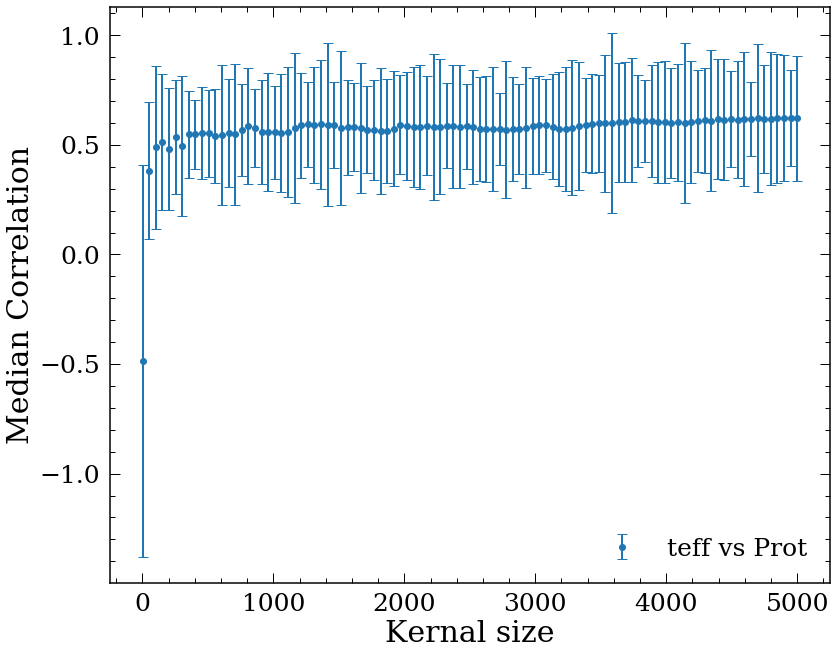

In [522]:
fig=plt.figure(figsize=(10,8))
ax=fig.add_axes([0,0,1,1])
for i in range(len(rCorr_all)):
    ax.errorbar(NN_a,rCorr_all[i],yerr=rCorr_err_all[i],fmt='o',barsabove=True,capsize=5,label=xnames[i]+' vs '+ynames[i])
    #ax.plot(NN_a,rCorr_all[i],'o--')
    ax.set_xlabel('Kernal size')
    ax.set_ylabel('Median Correlation')
plt.legend()


In [556]:
# recalculate for these stars
KID_recalc=Clusters_cm['KIC'].unique()
rCorr=[]
rCorr_err=[]
NN_a=[int(i) for i in np.linspace(2, 5000, num=100)]
for numbs in range(len(NN_a)):
    update_progress(numbs/len(NN_a))
    NN=NN_a[numbs] # how many nearest to find

    for i in range(len(KID_recalc)):
        teff = df_w_giants.loc[df_w_giants['KID']==KID_recalc[i]]['teff_norm'].values
        Prot = df_w_giants.loc[df_w_giants['KID']==KID_recalc[i]]['Prot_norm'].values
        
        df_w_giants['dist'] = np.sqrt(np.power(df_w_giants['teff_norm']-teff,2.)+np.power(df_w_giants['Prot_norm']-Prot,2.))
        # get the clossest stars v_b
        NNstars=df_w_giants.loc[df_w_giants.sort_values(by=['dist']).iloc[0:NN].index]
    
        MAD=sum(abs(NNstars['v_b']-np.median(NNstars['v_b'])))/float(len(NNstars))

        #print(df_w_giants['dv'].loc[df_w_giants['KID']==KID_recalc[i]])
        df_w_giants['dv'].loc[df_w_giants['KID']==KID_recalc[i]]=1.5*MAD
        #print(df_w_giants['dv'].loc[df_w_giants['KID']==KID_recalc[i]])
                                    
        df_w_giants['age_Rvar'].loc[df_w_giants['KID']==KID_recalc[i]]=p_lowz(df_w_giants['dv'].loc[df_w_giants['KID']==KID_recalc[i]])
    
    
    Clusters_cm=pd.merge(ASstars,df_w_giants,left_on='KIC',right_on='KID',how='inner')
    Clusters_cm

    #plt.figure()
    #plt.plot(Clusters_cm["Age"],Clusters_cm["age_Rvar"],'ro',label='Prot Age')
    #plt.plot([min(Clusters_cm["Age"]),max(Clusters_cm["Age"])],[min(Clusters_cm["Age"]),max(Clusters_cm["Age"])],'k--')
    
    #plt.xlabel('Astroseismic Ages [Gyr]')
    #plt.ylabel('Prot Ages [Gyr]')
    #plt.title('Kernal size '+str(NN),fontsize=25)
    
    pcount=1
    rs=[]
    rs_e=[]
    for pip in Clusters_cm['Pipe'].unique():
        plotCM=Clusters_cm.loc[Clusters_cm['Pipe']==pip]
        ages=plotCM["age_Rvar"].values
        rs.append(np.median([abs(i) for i in ((plotCM["Age"]-np.median(ages))/ages)]))
        
        

    rCorr.append(np.median(rs))
    
    
#rCorr
rCorr_all.append(rCorr)



Progress: [####################] 99.0%


No handles with labels found to put in legend.


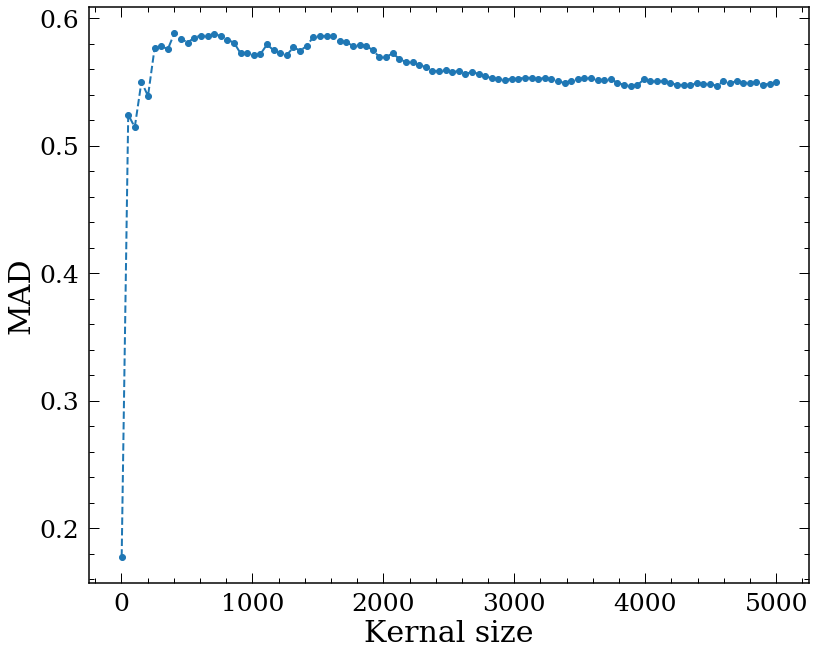

In [558]:
fig=plt.figure(figsize=(10,8))
ax=fig.add_axes([0,0,1,1])
for i in range(len(rCorr_all)):
    ax.plot(NN_a,rCorr_all[i],'o--')
    ax.set_xlabel('Kernal size')
    ax.set_ylabel('MAD')
plt.legend()



## In Rvar space

In [526]:
KID_as=[10666592,8554498, 11853905, 6521045, 8866102,
        3544595, 11904151, 5866724, 4914423, 8349582,
        5094751, 4349452, 8478994, 11295426, 8292840,
        11807274, 10514430, 3425851, 7670943, 8077137,
        10586004, 11133306, 11401755, 4141376, 4143755,
        6196457, 9592705, 8494142, 9414417, 3632418,
        10963065, 9955598, 6278762]
df_Rvar_giants.loc[df_Rvar_giants['KIDs'].isin(KID_as)]


solution_id                   designation     source_id  random_index  \
5436   1.635721e+18  Gaia DR2 2100020484108391808  2.100020e+18  2.002443e+08   
6809   1.635721e+18  Gaia DR2 2099606483621385216  2.099606e+18  2.799076e+08   
10434  1.635721e+18  Gaia DR2 2099656472742686848  2.099656e+18  1.301216e+09   
11647  1.635721e+18  Gaia DR2 2100451630105041152  2.100452e+18  1.464637e+09   
15811  1.635721e+18  Gaia DR2 2101243789577188736  2.101244e+18  1.590498e+09   
17694  1.635721e+18  Gaia DR2 2101175933393051008  2.101176e+18  4.130570e+08   
25872  1.635721e+18  Gaia DR2 2102119176929154304  2.102119e+18  7.045823e+08   
28950  1.635721e+18  Gaia DR2 2102224661326132864  2.102225e+18  7.219321e+08   
32189  1.635721e+18  Gaia DR2 2101733244046205568  2.101733e+18  6.430174e+08   
42627  1.635721e+18  Gaia DR2 2105620159389754624  2.105620e+18  1.091895e+09   
47145  1.635721e+18  Gaia DR2 2105318412166111232  2.105318e+18  1.633277e+09   
50059  1.635721e+18  Gaia DR2 2126918008858627712  2.126918e+18  1.024903e+09   
52494  1.635721e+18  Gaia DR2 2126237131982289280  2.126237e+18  3.517753e+08   
53097  1.635721e+18  Gaia DR2 2126945668448657664  2.126946e+18  1.056283e+09   
56269  1.635721e+18  Gaia DR2 2106904148451706752  2.106904e+18  1.216277e+07   
61719  1.635721e+18  Gaia DR2 2080386917291928832  2.080387e+18  3.404620e+08   
63658  1.635721e+18  Gaia DR2 2128069334973424000  2.128069e+18  9.403850e+08   
74255  1.635721e+18  Gaia DR2 2119635153070609920  2.119635e+18  1.502714e+08   
74949  1.635721e+18  Gaia DR2 2131494313689868416  2.131494e+18  8.146641e+08   
75684  1.635721e+18  Gaia DR2 2129256395211984000  2.129256e+18  8.778929e+07   
78452  1.635721e+18  Gaia DR2 2131593785132997632  2.131594e+18  2.582194e+08   
82591  1.635721e+18  Gaia DR2 2129931456691176576  2.129931e+18  1.891104e+08   
86023  1.635721e+18  Gaia DR2 2132885157240180864  2.132885e+18  1.979789e+08   
86381  1.635721e+18  Gaia DR2 2132152916856093952  2.132153e+18  2.143473e+08   

       gaia_ref_epoch          ra  ra_error        dec  dec_error   parallax  \
5436           2015.5  285.728907  0.026216  38.506900   0.029184   3.857983   
6809           2015.5  287.361967  0.025380  38.714138   0.029975   9.185911   
10434          2015.5  287.655020  0.019381  39.244172   0.023621   2.560864   
11647          2015.5  286.638391  0.019753  39.487904   0.022074   4.082242   
15811          2015.5  288.984551  0.018416  40.064486   0.022564   1.992298   
17694          2015.5  290.392679  0.018256  40.284907   0.024050   2.077283   
25872          2015.5  288.688722  0.023018  41.151108   0.024279   3.263839   
28950          2015.5  289.086061  0.018402  41.563022   0.021831   2.063474   
32189          2015.5  291.386129  0.015670  41.990139   0.018861   3.253698   
42627          2015.5  287.345674  0.021666  43.378389   0.025815   3.357786   
47145          2015.5  282.492262  0.019913  43.980244   0.023949   2.494212   
50059          2015.5  289.347363  0.022517  44.208444   0.029444   4.183632   
52494          2015.5  291.387740  0.020622  44.529047   0.025582   1.735663   
53097          2015.5  289.739730  0.068912  44.647347   0.078847   1.805763   
56269          2015.5  283.151045  0.018499  45.140084   0.021652   6.749535   
61719          2015.5  295.802872  0.021651  45.987966   0.033162   4.673791   
63658          2015.5  293.716466  0.021632  46.226688   0.023825   2.413656   
74255          2015.5  281.274163  0.020819  47.774410   0.024264   3.667591   
74949          2015.5  285.311184  0.022622  47.848477   0.025121   2.417323   
75684          2015.5  292.247190  0.017649  47.969543   0.019830   2.903105   
78452          2015.5  284.786216  0.029544  48.423262   0.034218  11.234578   
82591          2015.5  291.250186  0.018550  49.231807   0.023882   1.865433   
86023          2015.5  288.100931  0.028900  50.033684   0.030488   3.969611   
86381          2015.5  285.615449  0.019169  50.135771   0.024

In [527]:
ASstars=pd.read_table('/Users/lucy/Desktop/KeplerAges/ASage.webarchive',delimiter=',',skiprows=2)
ASstars=ASstars.dropna(subset=['KIC'])
ASstars

Pipe         KIC    Mass     Rad  log(g)     Age     Lum      rho  \
0    AST      1435467.0  1.3417  1.7029  4.1028  2.6679  4.2160  0.38250   
1    AST      2837475.0  1.3879  1.6201  4.1608  1.6573  4.5620  0.45960   
2    AST      3427720.0  1.0990  1.1145  4.3844  2.3521  1.5030  1.11780   
3    AST      3456181.0  1.5569  2.1784  3.9537  1.8812  7.3170  0.21210   
4    AST      3632418.0  1.4772  1.9481  4.0279  2.4261  5.3000  0.28140   
..      ...         ...     ...     ...     ...     ...     ...      ...   
391  YMCM    12069127.0  1.5894  2.3051  3.9134  1.7595  0.8694  0.18272   
392  YMCM    12069424.0  1.0760  1.2253  4.2930  7.5242  0.1784  0.82366   
393  YMCM    12069449.0  1.0298  1.1115  4.3585  7.2215  0.0867  1.05600   
394  YMCM    12258514.0  1.2704  1.6085  4.1287  4.2362  0.4791  0.42990   
395  YMCM    12317678.0  1.3408  1.8089  4.0500  2.2406  0.7479  0.31893   

       Dist    Xini    Yini    Xsup    Ysup    Xcen    Ycen  MCcore    Rbce  \
0    137.22  0.7020  0.2780  0.7020  0.2780  0.1160  0.8640  0.0590  0.8410   
1    118.27  0.7040  0.2770  0.7040  0.2770  0.3510  0.6300  0.0710  0.9200   
2     90.93  0.7060  0.2750  0.7340  0.2490  0.4240  0.5580  0.0000  0.7720   
3    249.36  0.7010  0.2770  0.7010  0.2770  0.0490  0.9290  0.0640  0.8760   
4    109.67  0.6960  0.2770  0.6960  0.2770  0.0390  0.9340  0.0600  0.8200   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
391  427.23  0.7115  0.2669  0.7115  0.2669  0.0868  0.8915  0.1086  0.8645   
392   21.20  0.7288  0.2505  0.7288  0.2505  0.0386  0.9408  0.0000  0.7255   
393   20.95  0.7186  0.2611  0.7385  0.2426  0.1403  0.8385  0.0000  0.7117   
394   80.69  0.7306  0.2499  0.7306  0.2499  0.0466  0.9339  0.0592  0.7755   
395  142.99  0.7258  0.2640  0.7258  0.2640  0.1373  0.8525  0.0912  0.9068   

      alpha    TAMS  
0    1.8000  2.9535  
1    1.8000  2.5932  
2    1.8000  6.6391  
3    1.8000  2.0413  
4    1.8000  2.6314  
..      ...     ...  
391  1.6715  1.8826  
392  1.6738  9.0157  
393  1.7610  9.7540  
394  1.6985  4.5702  
395  1.5152  2.3824  

[396 rows x 19 columns]

In [528]:
Clusters_cm=pd.merge(ASstars,df_Rvar_giants,left_on='KIC',right_on='KIDs',how='inner')
#Clusters_cm=pd.merge(ASstars,noProt,left_on='KIC',right_on='KIDs',how='inner')
Clusters_cm['age_Rvar']=p_lowz(Clusters_cm['dv'])

In [529]:
Clusters_cm['Pipe'].unique()

array(['AST   ', 'BASTA ', 'C2kSMO', 'GOE   ', 'V&amp;A   ', 'YMCM  '],
      dtype=object)

In [530]:
Clusters_cm['age_Rvar']

0      6.160491
1      6.160491
2      6.160491
3      6.160491
4      6.160491
         ...   
247    5.240948
248    5.240948
249    5.240948
250    5.240948
251    5.240948
Name: age_Rvar, Length: 252, dtype: float64

In [533]:
# recalculate for these stars
KID_recalc=Clusters_cm['KIC'].unique()
NN=500 # how many nearest to find
for i in range(len(KID_recalc)):
    update_progress(i/len(KID_recalc))
    print(KID_recalc[i])
    print('before:'+str(df_Rvar_giants['dv'].loc[df_Rvar_giants['KIDs']==KID_recalc[i]].values))
    teff = df_Rvar_giants.loc[df_Rvar_giants['KIDs']==KID_recalc[i]]['teff_norm']
    Prot = df_Rvar_giants.loc[df_Rvar_giants['KIDs']==KID_recalc[i]]['Rvars_27_norm']
    noProt['dist'] = np.sqrt(np.power(df_Rvar_giants['teff_norm']-teff,2.)+np.power(df_Rvar_giants['Rvars_27_norm']-Prot,2.))
    # get the clossest stars v_b
    NNstars=df_Rvar_giants.loc[df_Rvar_giants.sort_values(by=['dist']).iloc[0:NN].index]
    
    MAD=sum(abs(NNstars['v_b']-np.median(NNstars['v_b'])))/float(len(NNstars))

    df_Rvar_giants['dv'].loc[df_Rvar_giants['KIDs']==KID_recalc[i]]=1.5*MAD
    print('after:'+str(df_Rvar_giants['dv'].loc[df_Rvar_giants['KIDs']==KID_recalc[i]].values))
Agebefore=df_Rvar_giants['age_Rvar'].loc[df_Rvar_giants['KIDs'].isin(KID_recalc)]
df_Rvar_giants['age_Rvar']=p_lowz(df_Rvar_giants['dv'])
print('Net Age change:',sum(Agebefore-df_Rvar_giants['age_Rvar'].loc[df_Rvar_giants['KIDs'].isin(KID_recalc)]))


Progress: [####################] 97.6%
12317678.0
before:[18.02037448]
after:[17.71033362]
Net Age change: 4.021513217562795


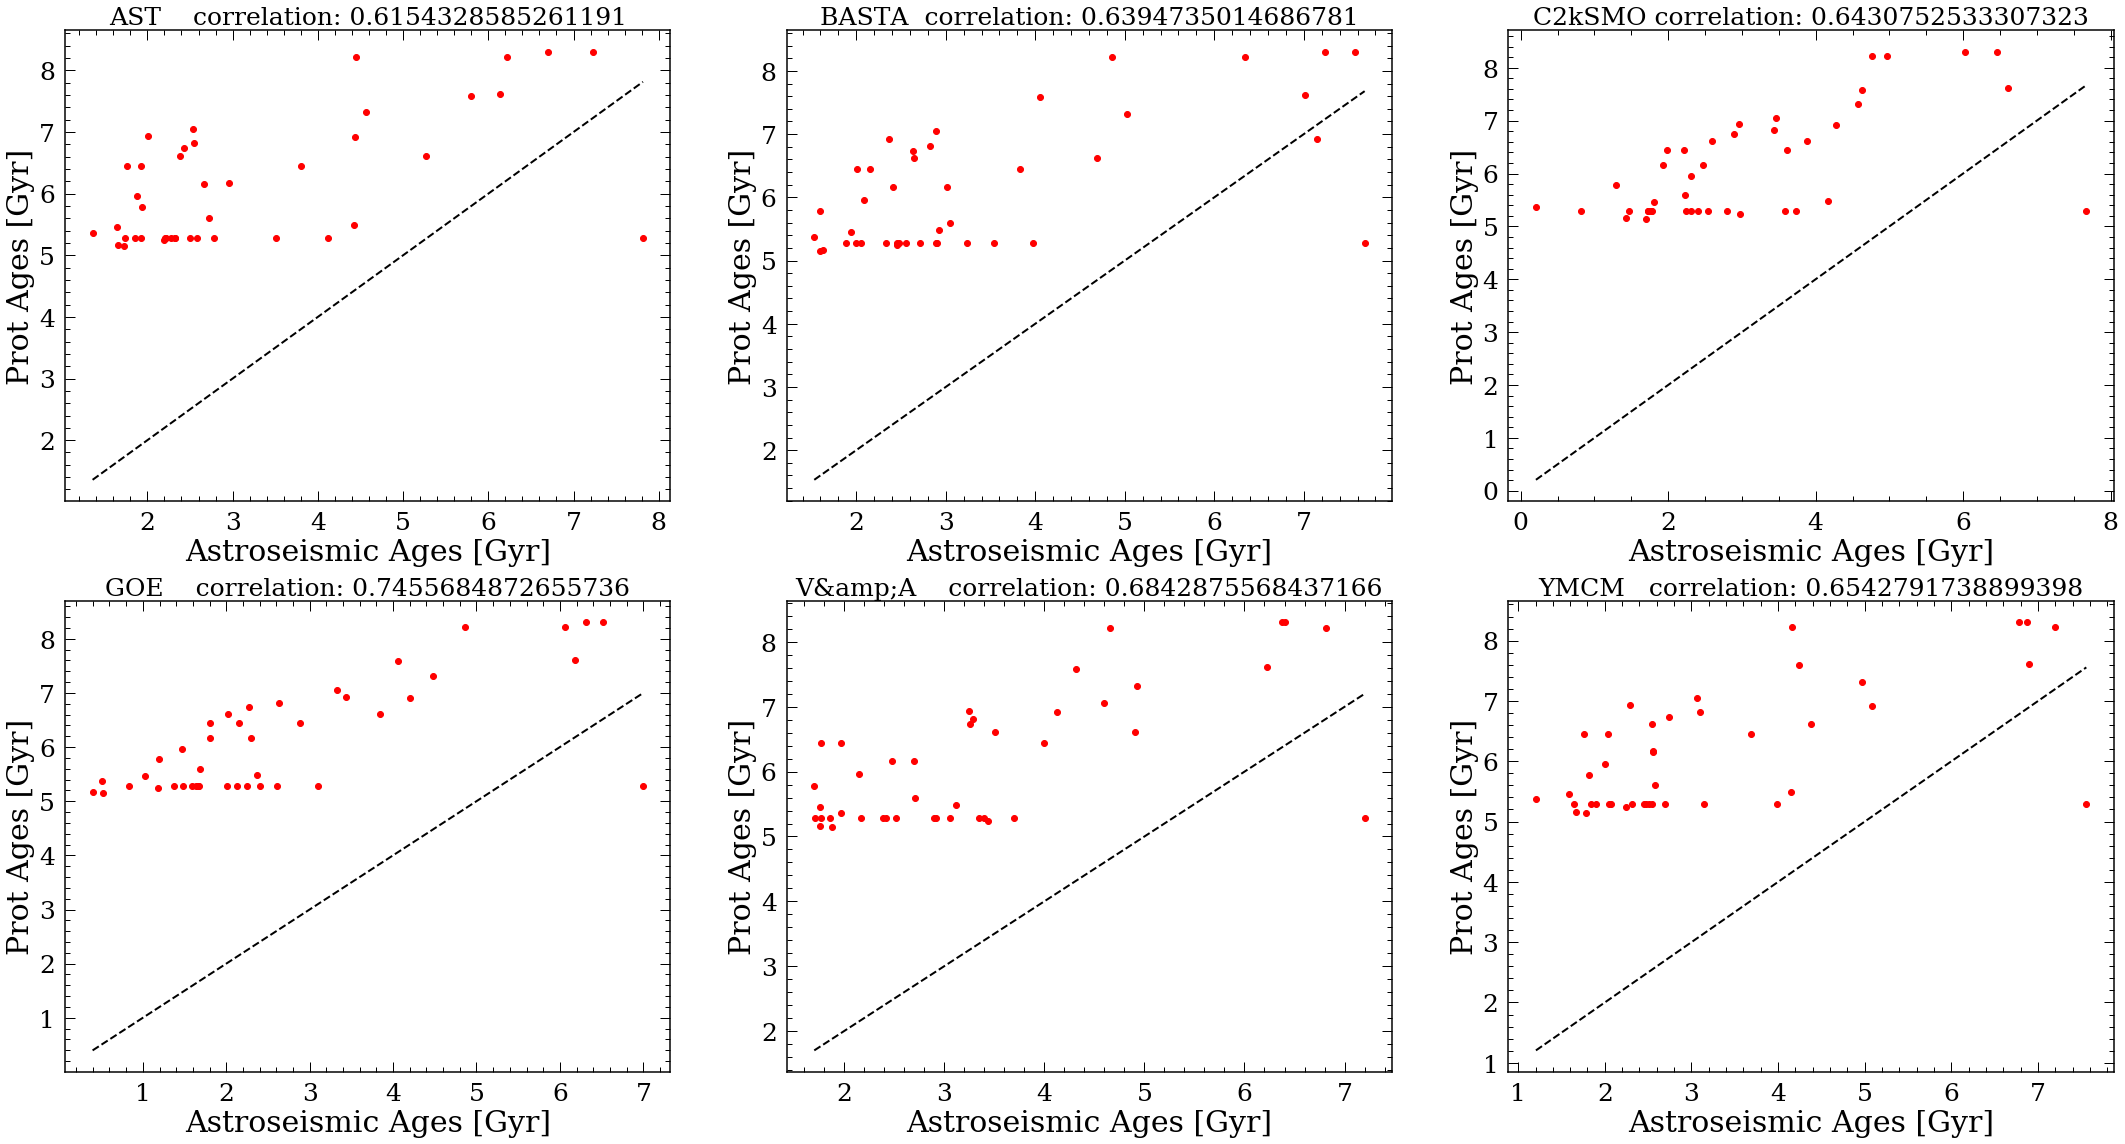

In [534]:
plt.figure(figsize=(30,16))
pcount=1
for pip in Clusters_cm['Pipe'].unique():
    plt.subplot(2,3,pcount)
    plotCM=Clusters_cm.loc[Clusters_cm['Pipe']==pip]
    #plt.plot(plotCM["Age"],plotCM["age_Prot"],'o',label='Prot Age')
    plt.plot(plotCM["Age"],plotCM["age_Rvar"],'ro',label='Rvar Age')
    plt.plot([min(plotCM["Age"]),max(plotCM["Age"])],[min(plotCM["Age"]),max(plotCM["Age"])],'k--')
    
    plt.xlabel('Astroseismic Ages [Gyr]')
    plt.ylabel('Prot Ages [Gyr]')
    r = np.corrcoef(plotCM["Age"], plotCM["age_Rvar"])
    plt.title(pip+' correlation: '+str(r[1][0]),fontsize=25)
    #plt.plot([1,1],[0,8],'r--',label=cluster)
    #plt.legend(loc='upper left')
    pcount=pcount+1
plt.tight_layout()
#plt.savefig('checkage.png')

Get best NN

In [497]:
xnames=[]
ynames=[]
rCorr_all_Rvar=[]
rCorr_err_all_Rvar=[]

before dropping 90635
after dropping 90635


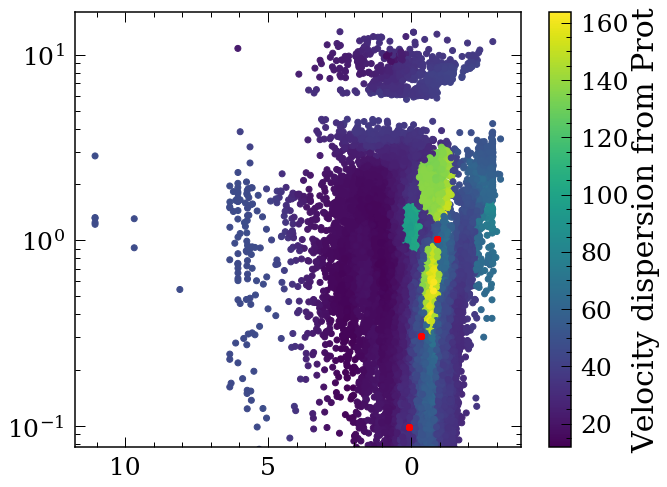

In [523]:
#noProt['Rvars_27_log']=np.log10(noProt['Rvars_27'])
xname='teff'
yname='Rvars_27'
df_Rvar_giants=df_Rvar_giants.dropna(subset=[xname,yname])
X_nn = StandardScaler().fit_transform(df_Rvar_giants[[xname,yname]])
df_Rvar_giants['teff_norm'],df_Rvar_giants['Prot_norm'] = X_nn[:,0], X_nn[:,1]

print('before dropping',len(df_Rvar_giants))
df_Rvar_giants=df_Rvar_giants.dropna(subset=['v_b'])
print('after dropping',len(df_Rvar_giants))

# drop velocities that are very high...
df_Rvar_giants=df_Rvar_giants.loc[df_Rvar_giants['v_b']<100].reset_index(drop=True)
df_Rvar_giants=df_Rvar_giants.loc[df_Rvar_giants['v_b']>-200].reset_index(drop=True)

# for each star calculate its nearest *NN* stars and calcualte velocity dispersion
Nstars=len(df_Rvar_giants)

xnames.append(xname)
ynames.append(yname)

plt.figure(figsize=(10,8))
plt.scatter(df_Rvar_giants['teff_norm'],df_Rvar_giants['Rvars_27_norm'],c=df_Rvar_giants['dv'])
plt.gca().invert_xaxis()
plt.plot(Clusters_cm['teff_norm'],Clusters_cm['Rvars_27_norm'],'ro')
plt.yscale('log')
cb=plt.colorbar()
cb.set_label('Velocity dispersion from Prot')

In [503]:
# recalculate for these stars
KID_recalc=Clusters_cm['KIC'].unique()
rCorr=[]
rCorr_err=[]
NN_a=[int(i) for i in np.linspace(2, 5000, num=100)]
for numbs in range(len(NN_a)):
    update_progress(numbs/len(NN_a))
    NN=NN_a[numbs] # how many nearest to find

    for i in range(len(KID_recalc)):
        teff = df_Rvar_giants.loc[df_Rvar_giants['KIDs']==KID_recalc[i]]['teff_norm'].values
        Prot = df_Rvar_giants.loc[df_Rvar_giants['KIDs']==KID_recalc[i]]['Prot_norm'].values
        
        df_Rvar_giants['dist'] = np.sqrt(np.power(df_Rvar_giants['teff_norm']-teff,2.)+np.power(df_Rvar_giants['Prot_norm']-Prot,2.))
        # get the clossest stars v_b
        NNstars=df_Rvar_giants.loc[df_Rvar_giants.sort_values(by=['dist']).iloc[0:NN].index]
    
        MAD=sum(abs(NNstars['v_b']-np.median(NNstars['v_b'])))/float(len(NNstars))

        #print(df_w_giants['dv'].loc[df_w_giants['KID']==KID_recalc[i]])
        df_Rvar_giants['dv'].loc[df_Rvar_giants['KIDs']==KID_recalc[i]]=1.5*MAD
        #print(df_w_giants['dv'].loc[df_w_giants['KID']==KID_recalc[i]])
                                    
        df_Rvar_giants['age_Rvar'].loc[df_Rvar_giants['KIDs']==KID_recalc[i]]=p_lowz(df_Rvar_giants['dv'].loc[df_Rvar_giants['KIDs']==KID_recalc[i]])
    
    
    Clusters_cm=pd.merge(ASstars,df_Rvar_giants,left_on='KIC',right_on='KIDs',how='inner')
    Clusters_cm

    #plt.figure()
    #plt.plot(Clusters_cm["Age"],Clusters_cm["age_Rvar"],'ro',label='Prot Age')
    #plt.plot([min(Clusters_cm["Age"]),max(Clusters_cm["Age"])],[min(Clusters_cm["Age"]),max(Clusters_cm["Age"])],'k--')
    
    #plt.xlabel('Astroseismic Ages [Gyr]')
    #plt.ylabel('Prot Ages [Gyr]')
    #plt.title('Kernal size '+str(NN),fontsize=25)
    
    pcount=1
    rs=[]
    rs_e=[]
    for pip in Clusters_cm['Pipe'].unique():
        plotCM=Clusters_cm.loc[Clusters_cm['Pipe']==pip]
        rs.append(np.corrcoef(plotCM["Age"], plotCM["age_Rvar"])[0][1])
        ages=plotCM["age_Rvar"].values
        rs_shuff=np.zeros(200)
        rs_shuff[0]=(np.corrcoef(plotCM["Age"], ages)[0][1])
        
        for k in range(1,200):
            #update_progress(k/200)
            random.shuffle(ages)
            rs_shuff[k]=(np.corrcoef(plotCM["Age"], ages)[0][1])
        
        hist, bin_edges = np.histogram(rs_shuff,bins=10,density=True)
        for cb in range(len(bin_edges)):
            if rs_shuff[0] <= bin_edges[cb]:
                rs_e.append(hist[cb-1])
        
        
    #print(rs)
    rCorr.append(np.median(rs))
    rCorr_err.append(np.median(rs_e))
    
    
#rCorr
rCorr_all_Rvar.append(rCorr)
rCorr_err_all_Rvar.append(rCorr_err)


Progress: [####################] 99.0%


(2, 5000)

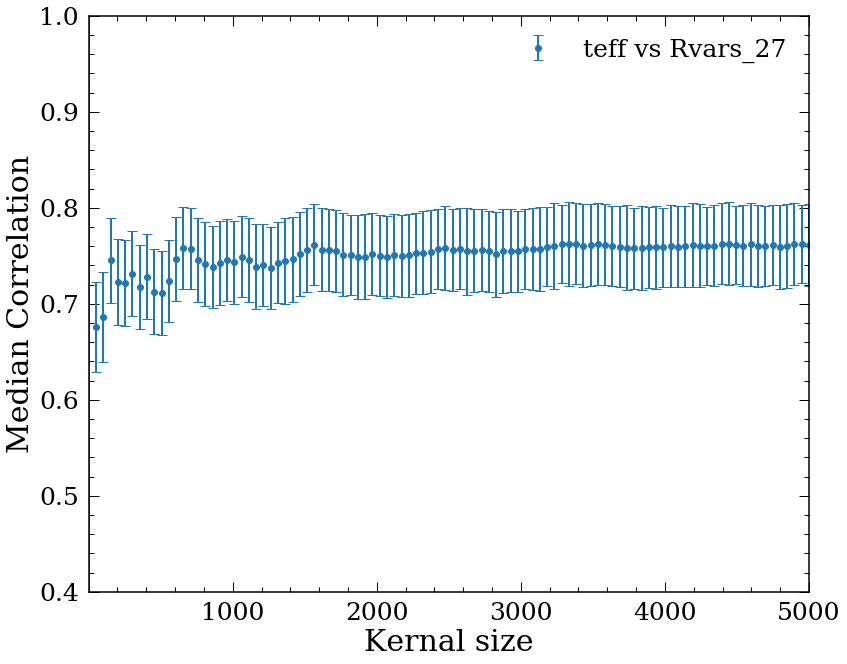

In [507]:
fig=plt.figure(figsize=(10,8))
ax=fig.add_axes([0,0,1,1])
for i in range(len(rCorr_all)):
    ax.errorbar(NN_a,rCorr_all_Rvar[i],yerr=rCorr_err_all_Rvar[i],fmt='o',barsabove=True,capsize=5,label=xnames[i]+' vs '+ynames[i])
    #ax.plot(NN_a,rCorr_all[i],'o--')
    ax.set_xlabel('Kernal size')
    ax.set_ylabel('Median Correlation')
plt.legend()
plt.ylim([0.4,1])
plt.xlim([2,5000])

MAD

In [542]:
xnames=[]
ynames=[]
rCorr_all_Rvar=[]
rCorr_err_all_Rvar=[]

In [543]:
# recalculate for these stars
KID_recalc=Clusters_cm['KIC'].unique()
rCorr=[]
rCorr_err=[]
NN_a=[int(i) for i in np.linspace(2, 5000, num=100)]
for numbs in range(len(NN_a)):
    update_progress(numbs/len(NN_a))
    NN=NN_a[numbs] # how many nearest to find

    for i in range(len(KID_recalc)):
        teff = df_Rvar_giants.loc[df_Rvar_giants['KIDs']==KID_recalc[i]]['teff_norm'].values
        Prot = df_Rvar_giants.loc[df_Rvar_giants['KIDs']==KID_recalc[i]]['Prot_norm'].values
        
        df_Rvar_giants['dist'] = np.sqrt(np.power(df_Rvar_giants['teff_norm']-teff,2.)+np.power(df_Rvar_giants['Prot_norm']-Prot,2.))
        # get the clossest stars v_b
        NNstars=df_Rvar_giants.loc[df_Rvar_giants.sort_values(by=['dist']).iloc[0:NN].index]
    
        MAD=sum(abs(NNstars['v_b']-np.median(NNstars['v_b'])))/float(len(NNstars))

        #print(df_w_giants['dv'].loc[df_w_giants['KID']==KID_recalc[i]])
        df_Rvar_giants['dv'].loc[df_Rvar_giants['KIDs']==KID_recalc[i]]=1.5*MAD
        #print(df_w_giants['dv'].loc[df_w_giants['KID']==KID_recalc[i]])
                                    
        df_Rvar_giants['age_Rvar'].loc[df_Rvar_giants['KIDs']==KID_recalc[i]]=p_lowz(df_Rvar_giants['dv'].loc[df_Rvar_giants['KIDs']==KID_recalc[i]])
    
    
    Clusters_cm=pd.merge(ASstars,df_Rvar_giants,left_on='KIC',right_on='KIDs',how='inner')
    Clusters_cm

    #plt.figure()
    #plt.plot(Clusters_cm["Age"],Clusters_cm["age_Rvar"],'ro',label='Prot Age')
    #plt.plot([min(Clusters_cm["Age"]),max(Clusters_cm["Age"])],[min(Clusters_cm["Age"]),max(Clusters_cm["Age"])],'k--')
    
    #plt.xlabel('Astroseismic Ages [Gyr]')
    #plt.ylabel('Prot Ages [Gyr]')
    #plt.title('Kernal size '+str(NN),fontsize=25)
    
    pcount=1
    rs=[]
    rs_e=[]
    for pip in Clusters_cm['Pipe'].unique():
        plotCM=Clusters_cm.loc[Clusters_cm['Pipe']==pip]
        ages=plotCM["age_Rvar"].values
        rs.append(np.median([abs(i) for i in ((plotCM["Age"]-np.median(ages))/ages)]))
        
        
    #print(rs)
    rCorr.append(np.median(rs_shuff))
    
    
#rCorr
rCorr_all_Rvar.append(rCorr)



Progress: [####################] 99.0%


No handles with labels found to put in legend.


(2, 5000)

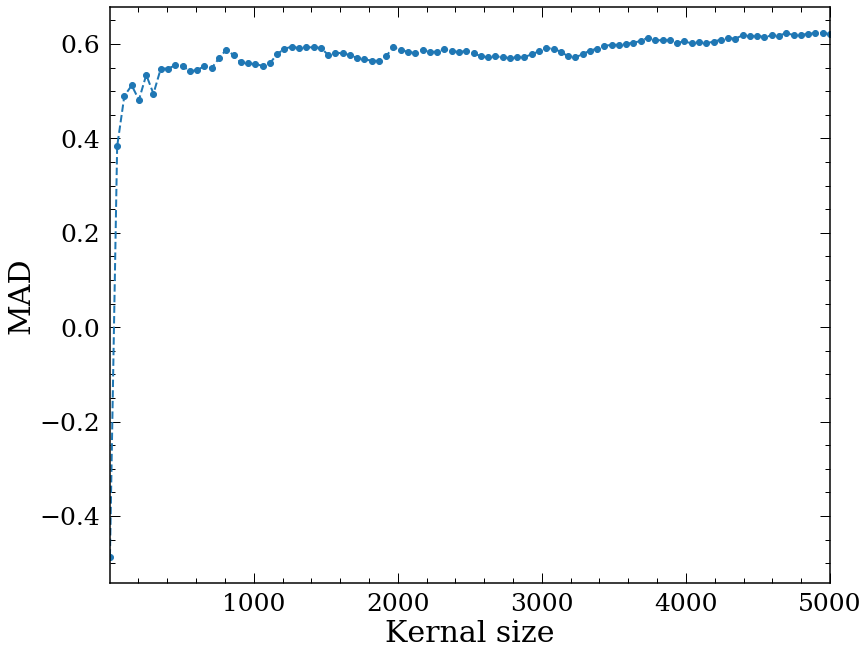

In [545]:
fig=plt.figure(figsize=(10,8))
ax=fig.add_axes([0,0,1,1])
for i in range(len(rCorr_all)):
    #ax.errorbar(NN_a,rCorr_all_Rvar[i],yerr=rCorr_err_all_Rvar[i],fmt='o',barsabove=True,capsize=5,label=xnames[i]+' vs '+ynames[i])
    ax.plot(NN_a,rCorr_all[i],'o--')
    ax.set_xlabel('Kernal size')
    ax.set_ylabel('MAD')
plt.legend()
#plt.ylim([0.4,1])
plt.xlim([2,5000])